In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


--------------------------
# Introduction

![](https://c.tenor.com/csSu8i3jaRQAAAAC/titanic-sinking.gif)

Picture Credit: https://c.tenor.com



### Missing Values

> For various reasons, many real world datasets contain missing values, often encoded as blanks, NaNs or other placeholders. Such datasets however are incompatible with scikit-learn estimators which assume that all values in an array are numerical, and that all have and hold meaning. A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data. 

Reference: https://scikit-learn.org/stable/

The first projects most people start with are probably titanic. However, As I think, titatic datasets are not easy.
The reason for thinking like this is as follows.
* Missing Values: There are many missing values of features that are considered important for survivor judgment, such as Age and Cabin.
* Small Dataset: Because the dataset is small, it seems difficult to train the model sufficiently.

In this notebook, we will focus on imputation of missing values and ensemble methods to improve performance.
In addition, we will create new derivative variables if necessary for each feature.

---------------------------------------------------------------
# Setting up

In [2]:
!pip install pycaret-nightly
!pip install missingno

     |████████████████████████████████| 288 kB 5.2 MB/s 
     |████████████████████████████████| 15.5 MB 58.4 MB/s 
     |████████████████████████████████| 167 kB 65.4 MB/s 
     |████████████████████████████████| 25.9 MB 52.5 MB/s 
     |████████████████████████████████| 10.4 MB 49.0 MB/s 
     |████████████████████████████████| 24.2 MB 62.0 MB/s 
     |████████████████████████████████| 113 kB 39.9 MB/s 
     |████████████████████████████████| 184 kB 63.4 MB/s 
     |████████████████████████████████| 1.0 MB 46.8 MB/s 
     |████████████████████████████████| 79 kB 6.1 MB/s 
     |████████████████████████████████| 58 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=776420b2587eb20a96ed09559cb7e6ff0e51c3553b240f95631780931f02912d
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filen

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
import umap
import umap.plot

import warnings
warnings.filterwarnings('ignore')

# Utility Function

In [4]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [5]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [6]:
def outlier_iqr(data):
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower = q1-(iqr*1.5)
    upper = q3+(iqr*1.5)
    return np.where((data>upper)|(data<lower))

In [7]:
def encode_features(dataDF,feat_list):
    for feature in feat_list:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

# Loading Dataset

In [8]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
submission_data = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
titanic_df = pd.concat([train_data, test_data], ignore_index = True, sort = False)
tr_idx = titanic_df['Survived'].notnull()

In [9]:
titanic_df.head(3).T.style.set_properties(**{'background-color': 'lightyellow',
                           'color': 'darkblack',
                           'border-color': 'darkblack'})

,0,1,2
PassengerId,1,2,3
Survived,0.000000,1.000000,1.000000
Pclass,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Thayer)","Heikkinen, Miss. Laina"
Sex,male,female,female
Age,22.000000,38.000000,26.000000
SibSp,1,1,0
Parch,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282
Fare,7.250000,71.283300,7.925000


In [10]:
titanic_df.shape

(1309, 12)

PassengerId has nothing to do with survior. It can be removed immediately.

In [11]:
titanic_df.drop(['PassengerId'],axis=1,inplace=True)

--------------------------------------------
# EDA

## Checking Data Type

In [12]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB


# Checking Target Value Imbalace

In [13]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


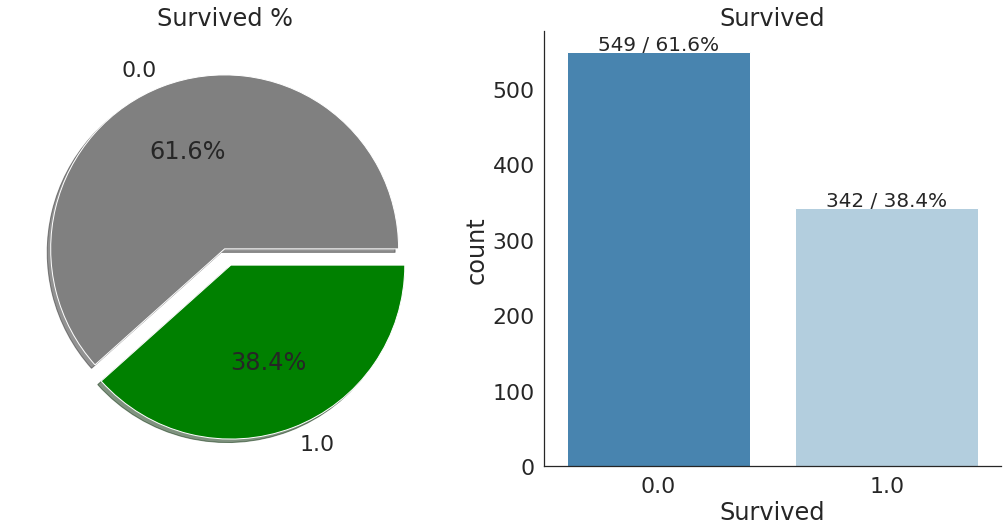

In [14]:
total_cnt = titanic_df['Survived'].count()
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
f, ax = plt.subplots(1, 2, figsize = (18, 8))
titanic_df['Survived'].value_counts().plot.pie(explode = [0, 0.1], 
                                               autopct = '%1.1f%%', 
                                               ax = ax[0],
                                               shadow = True,
                                               colors = ['grey', 'green'])
ax[0].set_title('Survived %')
ax[0].set_ylabel('')
sns.countplot('Survived', data = titanic_df, ax = ax[1], palette='Blues_r')
ax[1].set_title('Survived')
for p in ax[1].patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax[1].text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
sns.despine()

Although the survivor is small, the imbalance is not large enough for over/under sampling.
If you want to know more about over/under sampling, please refer to the notebook below.

[Over/Under sampling](https://www.kaggle.com/ohseokkim/preprocessing-resolving-imbalance-by-sampling)

## Checking and Handling Missing Values

<AxesSubplot:>

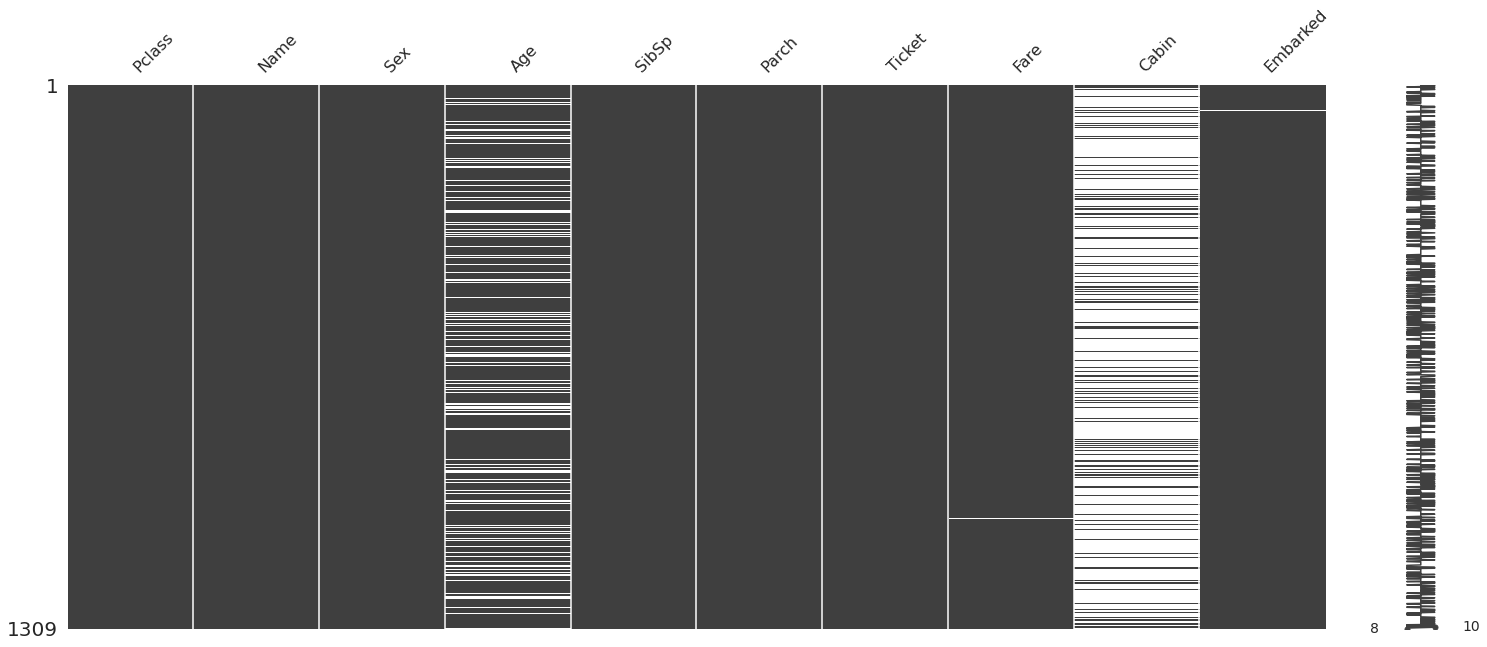

In [15]:
import missingno as msno
msno.matrix(titanic_df.drop(['Survived'],axis=1))

In [16]:
titanic_df.drop(['Survived'],axis=1).isnull().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

<span style="color:Blue"> Observation:
    
There are missing values for Age, Cabin, Fare, and Embarked features. In particular, there are many missing values for Age and Cabin features. Let's think about how to handle these missing values.

-------------------------------------
# Checking features

## Cabin

![](https://www.retrograph.com/wp-content/uploads/thumbnails/s5RGL181.jpg)

Picture Credit: https://www.retrograph.com

Looking at the picture above, it can be hypothesized that the survival rate will be different depending on the location of the cabin.

If you are the captain or sailor of titanic, you will be able to explain the relationship between cabin and survival rate well. If you have some kind of domain knowledge, you will be able to process that feature well. However, in the absence of such domain knowledge, we must examine the corresponding features in detail and process them to be suitable for machine learning.

In [17]:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

The first letter is an uppercase letter of the alphabet. Let's analyze it a bit more using this.

In [18]:
titanic_df['Cabin'].isnull().sum()

1014

<span style="color:Blue"> Observation:
    
Missing values are 1014. This is used to determine whether the cabin is owned or not. To do this, create a new derived variable.

------------------------------------------------------------------------
## Has_Cabin ( Derived variable )

**Question: Is there a difference in the survival rate between passengers with and without cabin?**

In [19]:
titanic_df['Has_Cabin'] = titanic_df['Cabin'].isnull().astype(int)

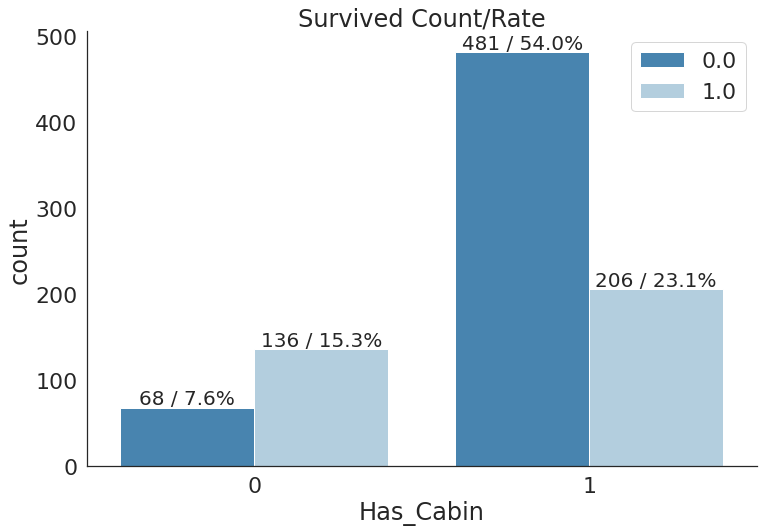

In [20]:
total_cnt = titanic_df['Survived'].count()
rcParams['figure.figsize'] = 12,8
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(x="Has_Cabin",
                   hue="Survived", 
                   data=titanic_df,
                   palette = 'Blues_r')
ax.set_title('Survived Count/Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
sns.despine()

<span style="color:Blue"> Observation:

* Cases with cabins have more survivors compared to cases without cabins. It is likely that the new derived variable will be helpful in the classification of survivors.

---------------------------------------------
## Cabin_Label ( Derived variable )

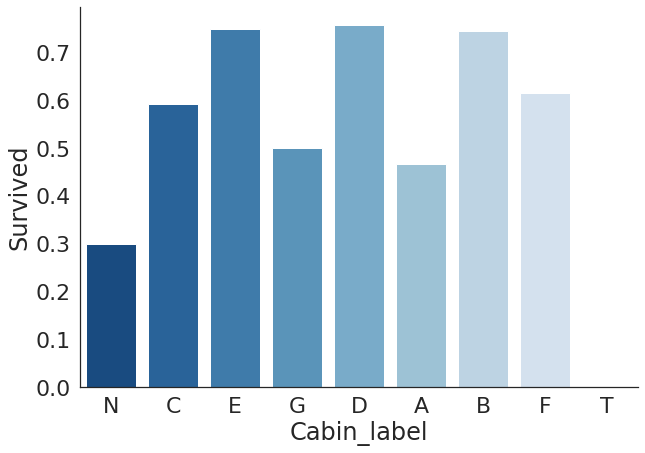

In [21]:
rcParams['figure.figsize'] = 10,7
sns.set(font_scale = 2)
sns.set_style("white")
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('N')
titanic_df['Cabin_label'] = titanic_df['Cabin'].str.get(0)
ax = sns.barplot(x = 'Cabin_label', y = 'Survived', data = titanic_df, palette = 'Blues_r',ci=False)
sns.despine()

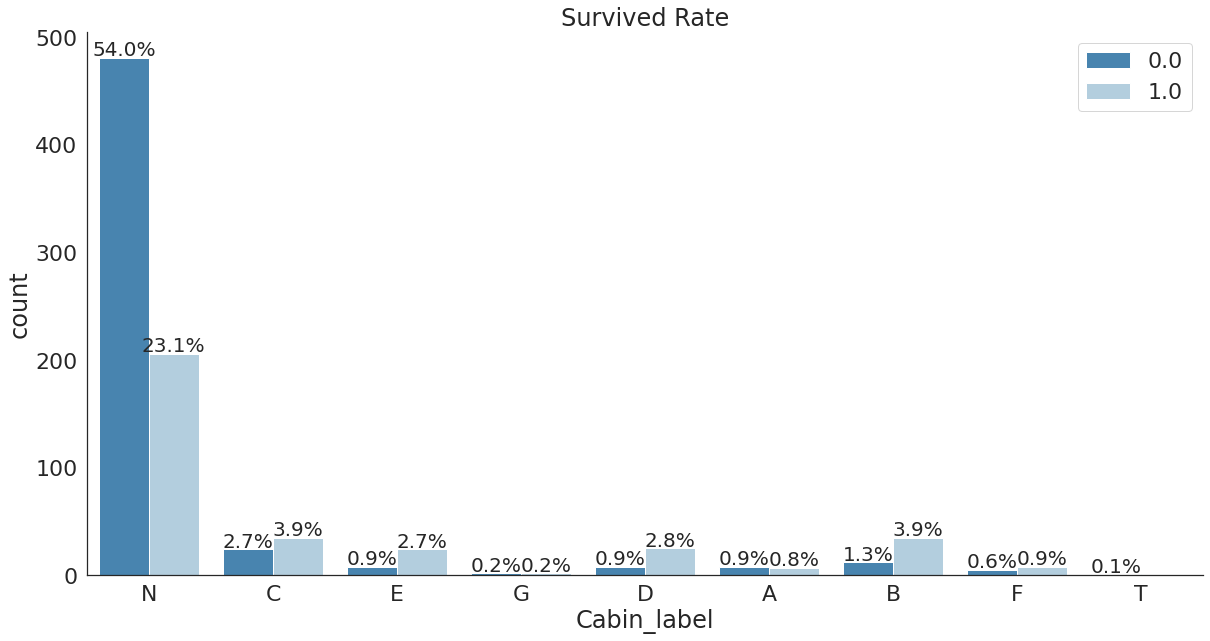

In [22]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(x="Cabin_label", hue="Survived", data=titanic_df,palette = 'Blues_r')
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

------------------------------------------------
## Parch ( Number of parents/children )

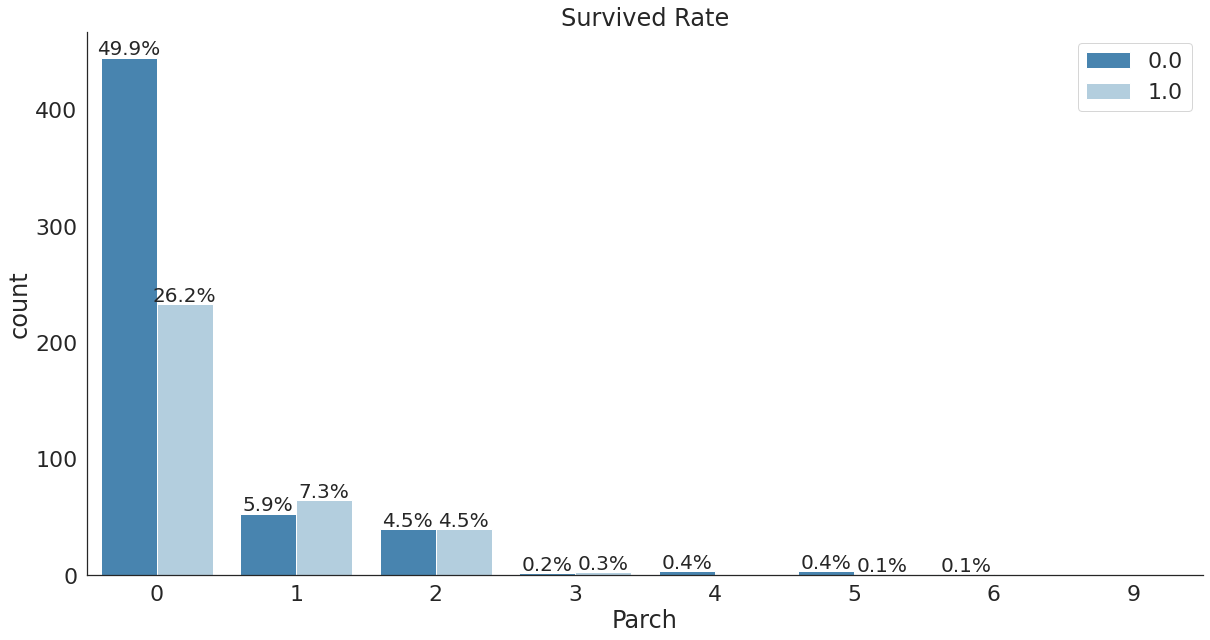

In [23]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='Parch',hue ='Survived',data=titanic_df,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

----------------------------------------------------------------------
## SibSp ( Number of siblings/spouses )

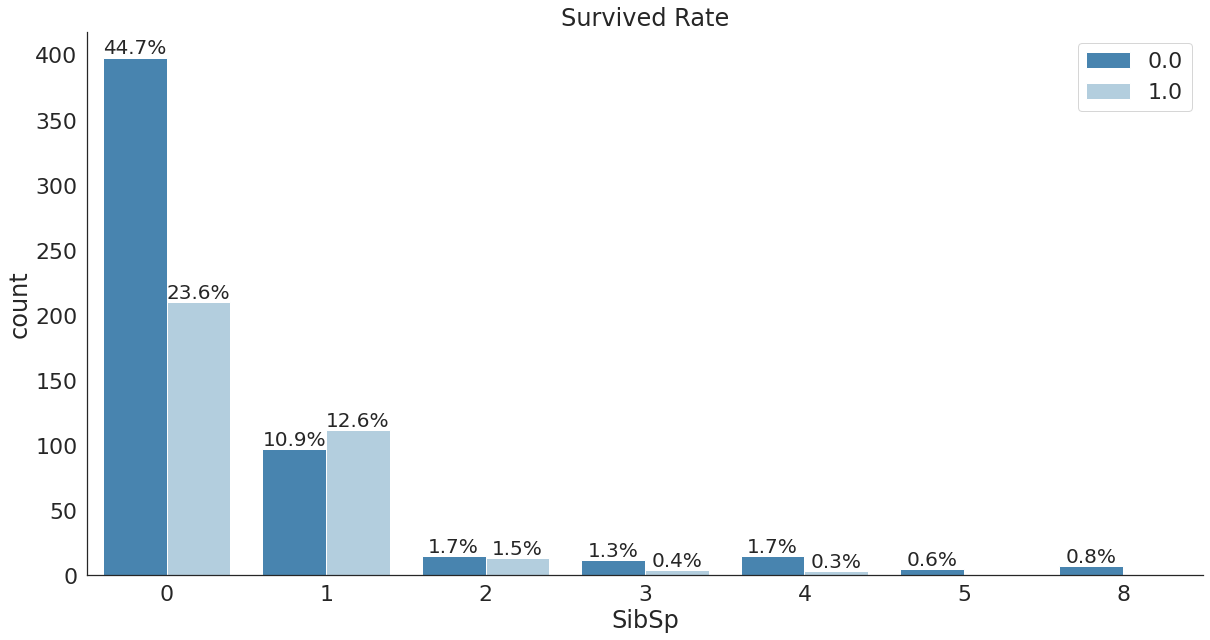

In [24]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='SibSp',hue ='Survived',data=titanic_df,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

-------------------------------------------------
## FamilySize ( Derived variable )

**Question: Does the number of accompanying family members affect the survival rate??**

In [25]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

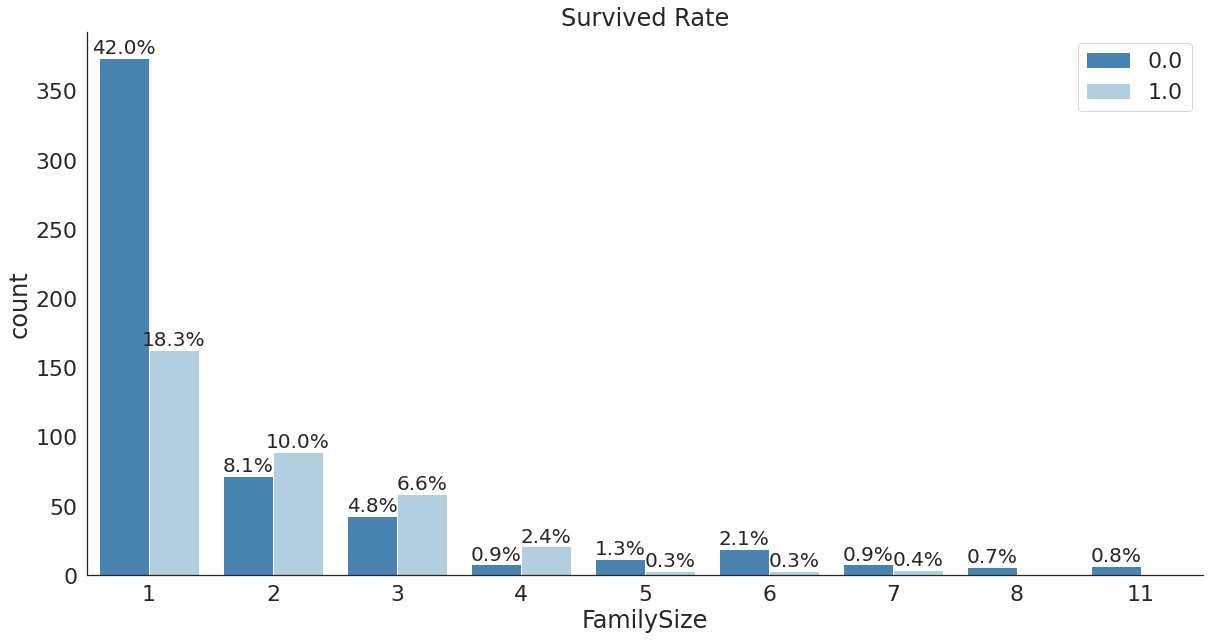

In [26]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='FamilySize',hue ='Survived',data=titanic_df,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=20)
sns.despine()

<span style="color:Blue"> Observation:

When FamilySize is 1, the survival rate is significantly lower than in other cases. I think it will be helpful when the model is learning.

______________________________________________
## Alone ( Derived variable )

In [27]:
titanic_df['IsAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'IsAlone'] = 1

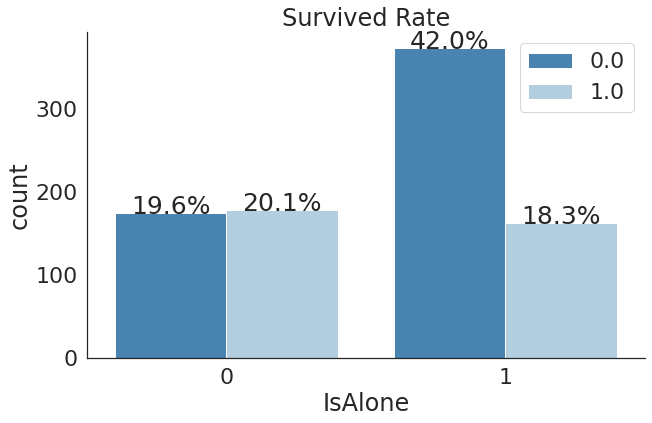

In [28]:
rcParams['figure.figsize'] = 10,6
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='IsAlone',hue ='Survived',data=titanic_df,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=25)
sns.despine()

<span style="color:Blue"> Observation:

Those who were alone died more than those who were not alone. The derived feature seems to be helpful for model training.

________________________________________________________
## Name

It seems difficult to find the feature directly related to the survivor.

In [29]:
titanic_df['Name'].unique()[:5]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry'], dtype=object)

English honistic looks. Let's check some more.

In [30]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

titanic_df['Title'] = titanic_df['Name'].apply(get_title)

In [31]:
titanic_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [32]:
titanic_df['Title'] = titanic_df['Title'].replace(
       ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
       'Rare')

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')
titanic_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

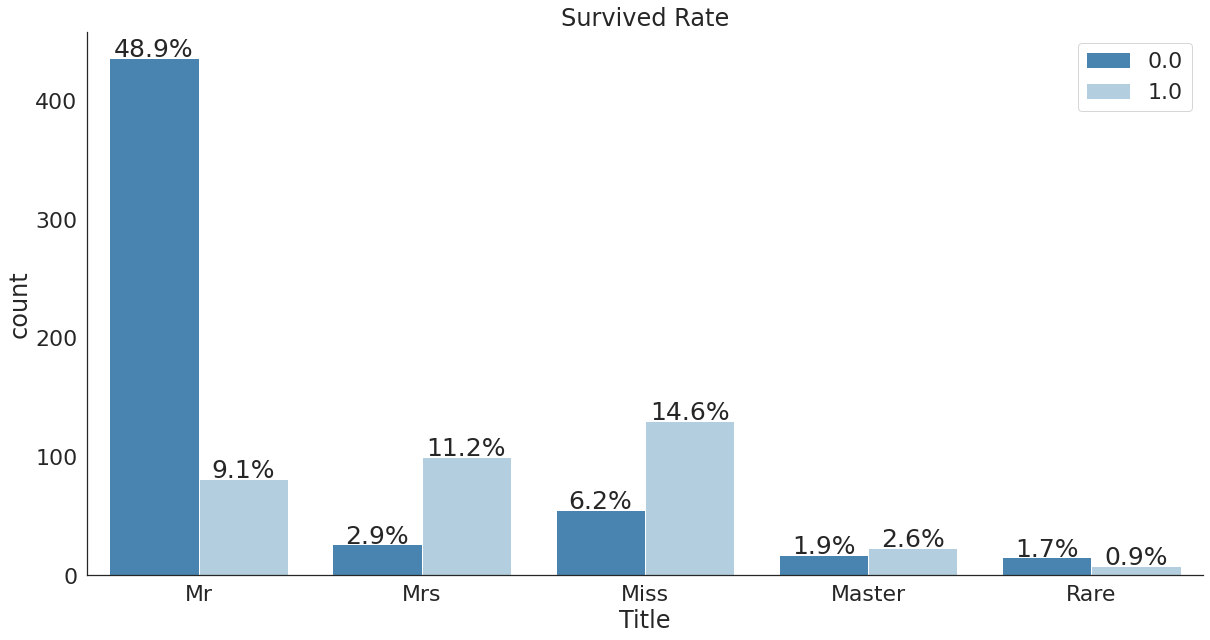

In [33]:
rcParams['figure.figsize'] = 20,10
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='Title',hue ='Survived',data=titanic_df,palette="Blues_r")
ax.set_title('Survived Rate')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=25)
sns.despine()

<span style="color:Blue"> Observation:

The mortality rate is higher in the case of Mr. I think it will help with learning.

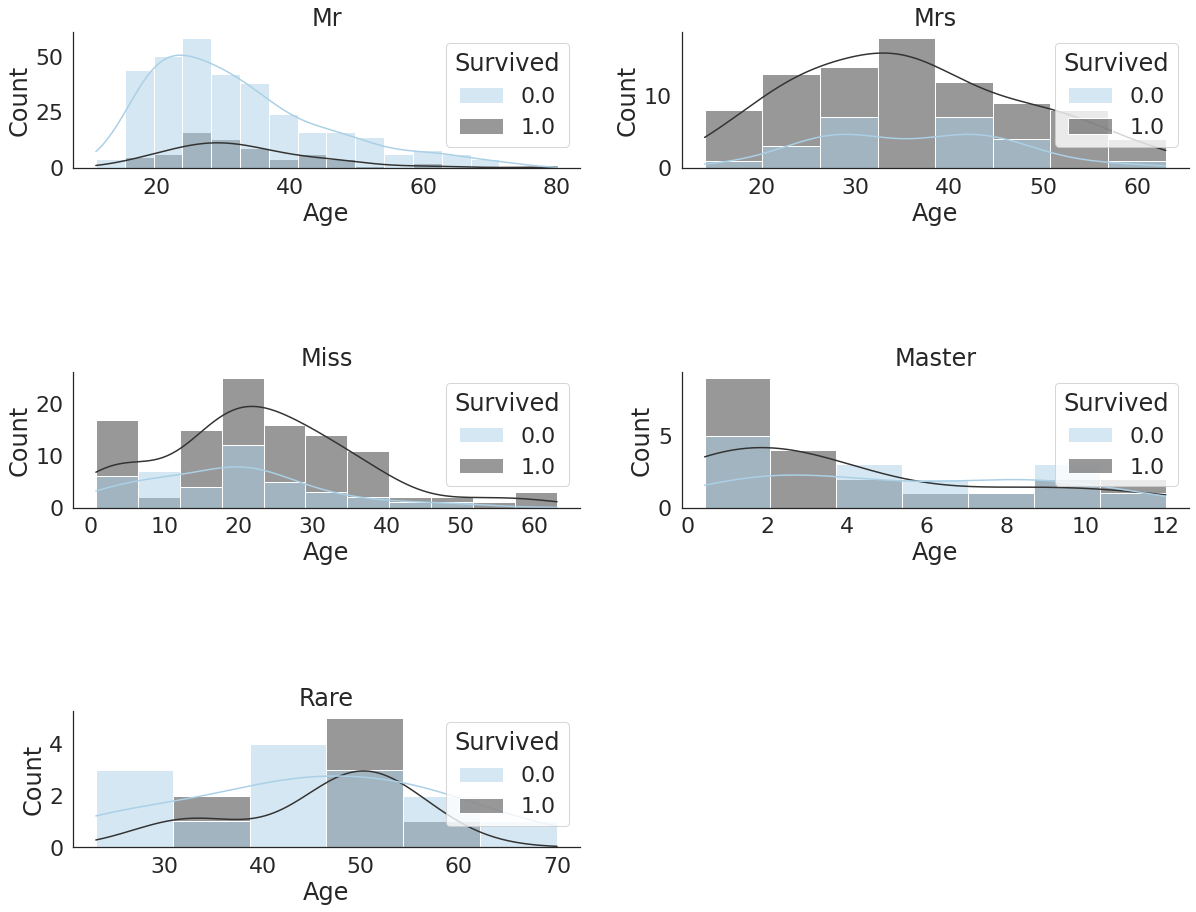

In [34]:
rcParams['figure.figsize'] = 20,15
titles = titanic_df['Title'].unique()
plt.subplots_adjust(hspace=1.5)
idx = 1
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")

for title in titles:
    plt.subplot(3,2,idx)
    ax = sns.histplot(x='Age',data=titanic_df[titanic_df['Title']== title],hue ='Survived',palette="Blues_d",kde=True)
    ax.set_title(title)
    sns.despine()
    idx = idx + 1

<span style="color:Blue"> Observation:
* In the case of Mr, the number of survivors is small.
* In the case of Mrs and Miss, there are many survivors.

I think it will be helpful in judging survivors using this.
However, it seems difficult to find the relationship between age and title from the above distributions. Therefore, it seems difficult to use this to fill in the missing values of age.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Has_Age ( Derived variable )

**Question: Does the survival rate make a difference with and without age records?|**

In [35]:
titanic_df['Age'].isnull().sum()

263

Let's check the distribution first to fill in the appropriate values.

### An Extension To Imputation

> Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing.

![](https://i.imgur.com/UWOyg4a.png)

> In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.
> 
> In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.

Ref: https://www.kaggle.com/alexisbcook/missing-values

In [36]:
titanic_df['Has_Age'] = titanic_df['Age'].isnull().astype(int)

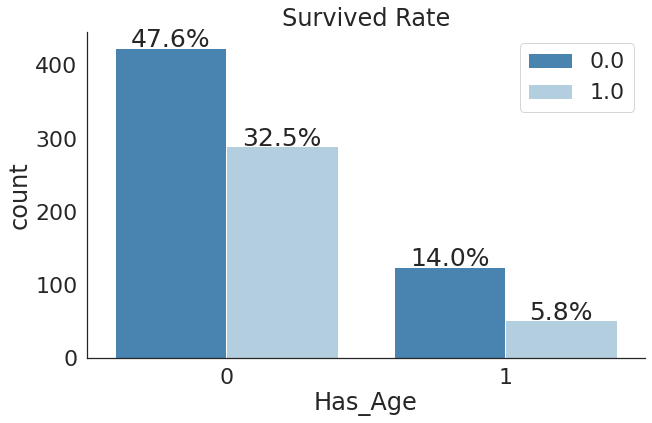

In [37]:
rcParams['figure.figsize'] = 10,6
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
ax = sns.countplot(x='Has_Age',hue ='Survived',data=titanic_df,palette="Blues_r")
plt.legend(loc = 'upper right')
ax.set_title('Survived Rate')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10,f'{height / total_cnt * 100:2.1f}%',va='center', ha='center', size=25)
sns.despine()

<span style="color:Blue"> Observation:
    
* More than the case where Age is not missing.
* Cases in which age is not missed have a higher survival rate than cases in which age is omitted.

-------------------------------------------------------------------------
## Age

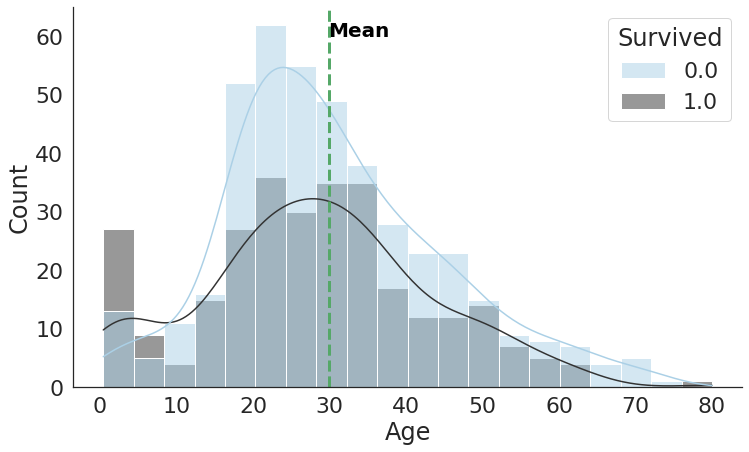

In [38]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.histplot(x="Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [39]:
mean = titanic_df['Age'].mean()
std = titanic_df['Age'].std()
skew = titanic_df['Age'].skew()
print('Age : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age : mean: 29.8811, std: 14.4135, skew: 0.4077


Looking at the skewness, it is skewed to one side.

## Imputting Missing Values

### Univariate feature imputation

> The SimpleImputer class provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

Ref: https://scikit-learn.org/stable/

In [40]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
titanic_df[['Age_mean']] = imp.fit_transform(titanic_df[['Age']])

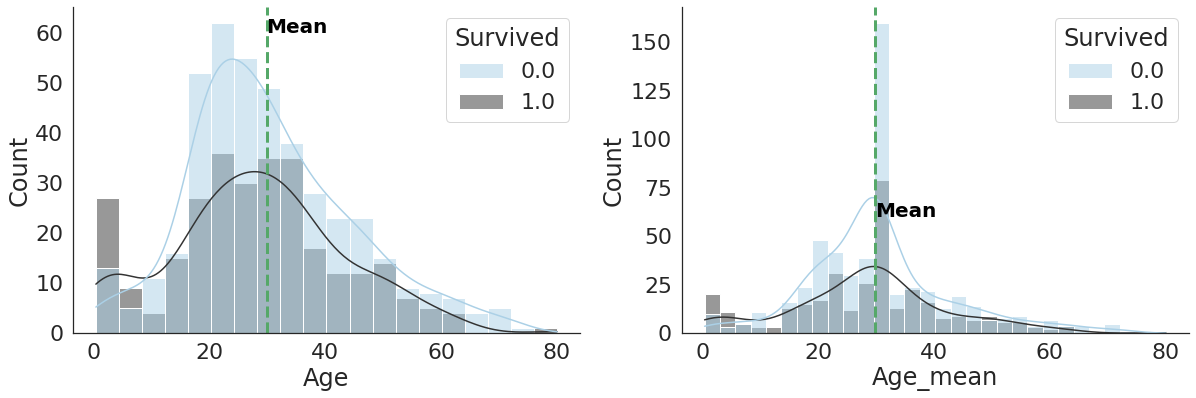

In [41]:
rcParams['figure.figsize'] = 20,6
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplot(1,2,1)
ax = sns.histplot(x="Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()
plt.subplot(1,2,2)
ax = sns.histplot(x="Age_mean", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age_mean'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age_mean'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [42]:
mean = titanic_df['Age_mean'].mean()
std = titanic_df['Age_mean'].std()
skew = titanic_df['Age_mean'].skew()
print('Age_mean : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age_mean : mean: 29.8811, std: 12.8832, skew: 0.4559


### Multivariate feature imputation

> A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.

Ref: https://scikit-learn.org/stable/

In [43]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
titanic_df[['Age_iter']] = imp.fit_transform(titanic_df[['Age']])

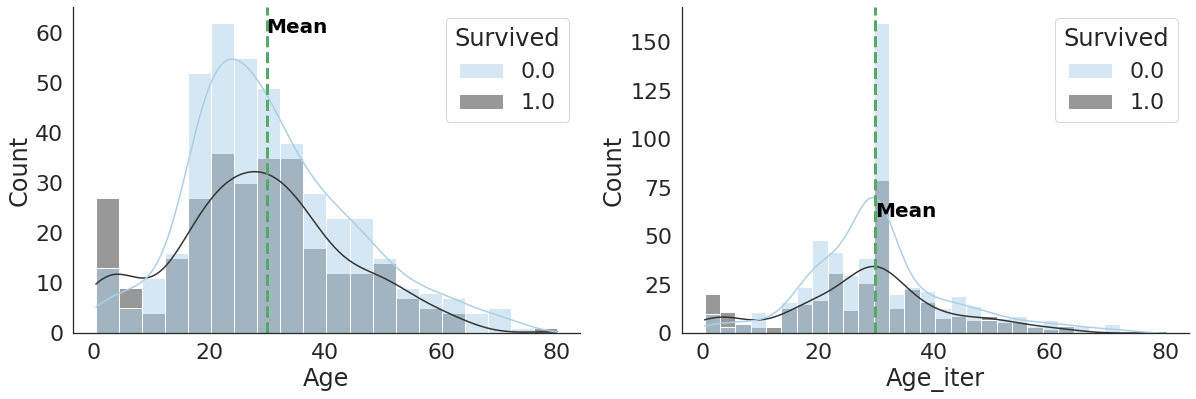

In [44]:
rcParams['figure.figsize'] = 20,6
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplot(1,2,1)
ax = sns.histplot(x="Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()
plt.subplot(1,2,2)
ax = sns.histplot(x="Age_iter", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age_iter'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age_iter'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [45]:
mean = titanic_df['Age_iter'].mean()
std = titanic_df['Age_iter'].std()
skew = titanic_df['Age_iter'].skew()
print('Age_iter : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age_iter : mean: 29.8811, std: 12.8832, skew: 0.4559


### Nearest neighbors imputation

> The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. When the number of available neighbors is less than n_neighbors and there are no defined distances to the training set, the training set average for that feature is used during imputation. If there is at least one neighbor with a defined distance, the weighted or unweighted average of the remaining neighbors will be used during imputation. If a feature is always missing in training, it is removed during transform. 

Ref: https://scikit-learn.org/stable/

In [46]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
titanic_df[['Age_knn']] = imputer.fit_transform(titanic_df[['Age']])

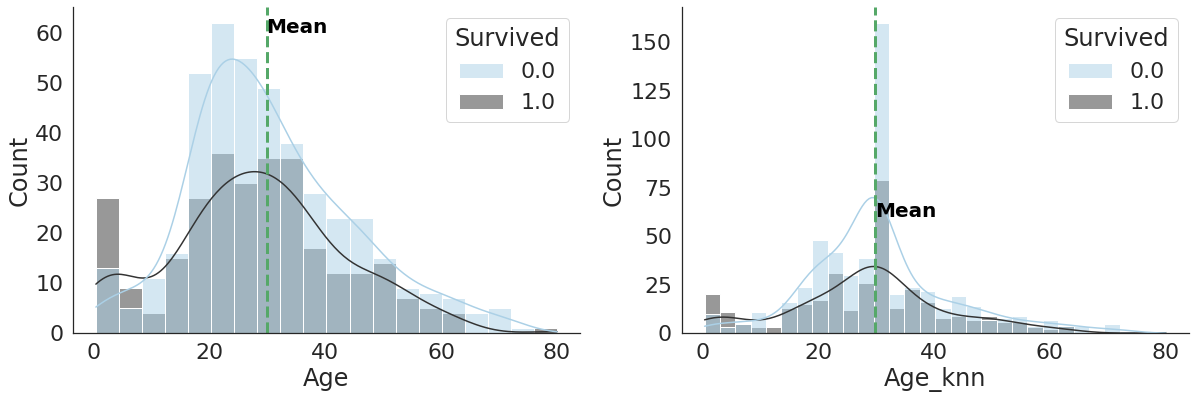

In [47]:
rcParams['figure.figsize'] = 20,6
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplot(1,2,1)
ax = sns.histplot(x="Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()
plt.subplot(1,2,2)
ax = sns.histplot(x="Age_knn", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age_knn'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age_knn'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [48]:
mean = titanic_df['Age_knn'].mean()
std = titanic_df['Age_knn'].std()
skew = titanic_df['Age_knn'].skew()
print('Age_knn : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age_knn : mean: 29.8811, std: 12.8832, skew: 0.4559


### Filling using other features

Another conceivable strategy is to use other features to fill in the missing values ​​of the Age feature. Consider how to fill the Age feature using the Title feature above.

In [49]:
titanic_df['new_Age'] = titanic_df['Age']

In [50]:
for title in titles:   
    t_mean = titanic_df[titanic_df['Title']== title]
    print('{} mean ===> {}'.format(title, t_mean['new_Age'].mean()))

Mr mean ===> 32.25215146299484
Mrs mean ===> 36.91812865497076
Miss mean ===> 21.8243661971831
Master mean ===> 5.482641509433963
Rare mean ===> 45.17857142857143


In [51]:
titanic_df['new_Age'].fillna(titanic_df.groupby('Title')['new_Age'].transform('mean'), inplace=True)

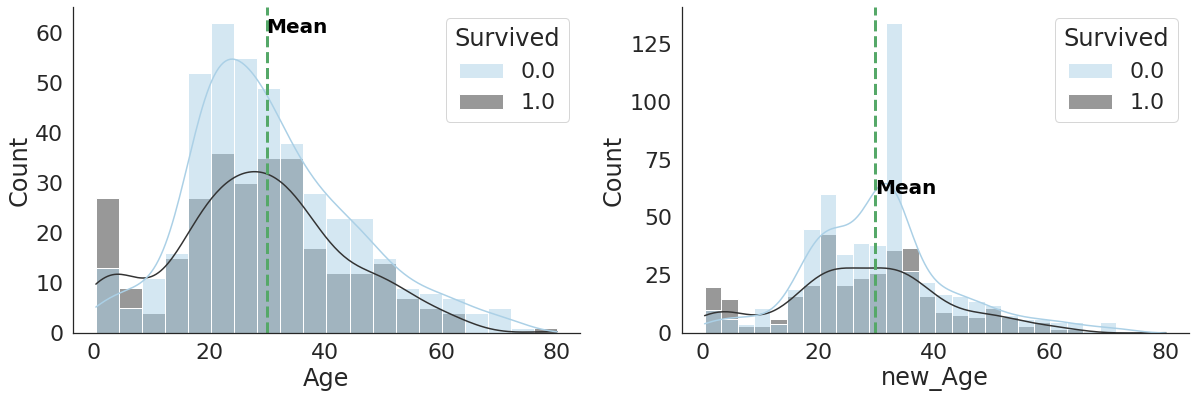

In [52]:
rcParams['figure.figsize'] = 20,6
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplot(1,2,1)
ax = sns.histplot(x="Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()
plt.subplot(1,2,2)
ax = sns.histplot(x="new_Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['new_Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['new_Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [53]:
mean = titanic_df['new_Age'].mean()
std = titanic_df['new_Age'].std()
skew = titanic_df['new_Age'].skew()
print('new_Age : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

new_Age : mean: 29.8938, std: 13.1949, skew: 0.3790


### Scaling 
Looking at the above result, the skewness was 0.4559, not skewed to one side. Let's try linear scaling.

Select RobustScaler during linear scaling. In this way, the influence of outliers can be minimized.

> This is a technique that minimizes the influence of outliers.  
> Since the median and IQR (interquartile range) are used, it can be confirmed that the same values are more widely distributed after standardization when compared with the StandardScaler.
> 
> $𝐼𝑄𝑅=𝑄3−𝑄1$: That is, it deals with values in the 25th and 75th percentiles.

If you want to know more about Scaling, please refer to the notebook below.

[NotebooK](https://www.kaggle.com/ohseokkim/preprocessing-linear-nonlinear-scaling)

In [54]:
from sklearn.preprocessing import RobustScaler
robuster = RobustScaler()
titanic_df['Age_knn'] = robuster.fit_transform(titanic_df[['Age_knn']])

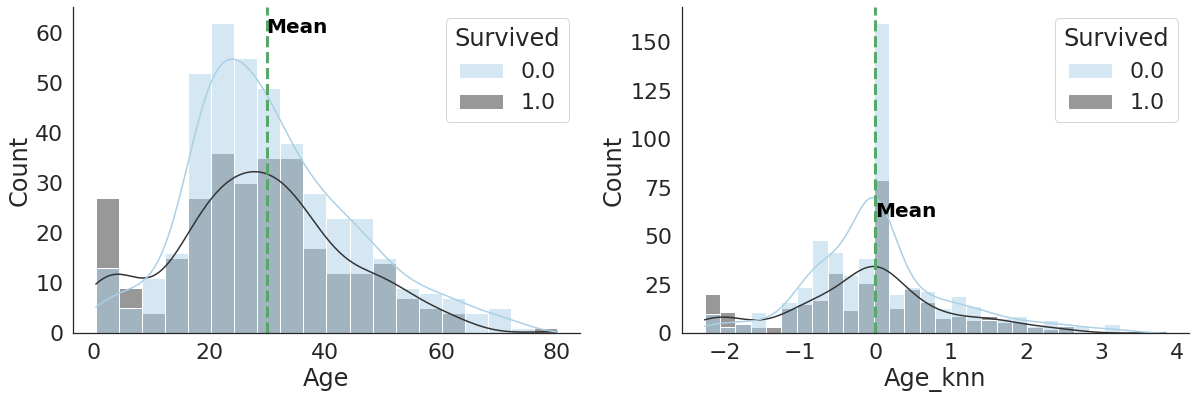

In [55]:
rcParams['figure.figsize'] = 20,6
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
plt.subplot(1,2,1)
ax = sns.histplot(x="Age", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()
plt.subplot(1,2,2)
ax = sns.histplot(x="Age_knn", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Age_knn'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Age_knn'].mean(), 60, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [56]:
mean = titanic_df['Age_knn'].mean()
std = titanic_df['Age_knn'].std()
skew = titanic_df['Age_knn'].skew()
print('Age_knn : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Age_knn : mean: 0.0000, std: 0.9910, skew: 0.4559


**Let imputation be done with KNN. The remaining Age-related features are removed.**

In [57]:
titanic_df.drop(['Age','Age_mean','Age_iter','new_Age'],axis=1,inplace=True)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Fare

First, let's check the distribution for that value.

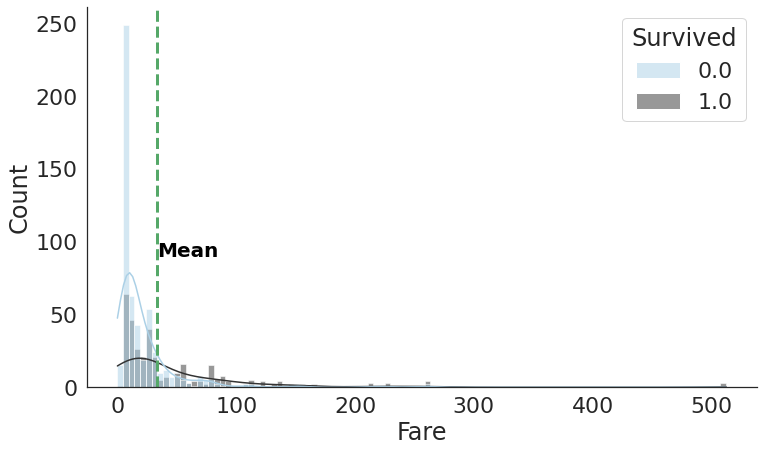

In [58]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.histplot(x="Fare", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Fare'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(titanic_df['Fare'].mean(), 90, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

In [59]:
mean = titanic_df['Fare'].mean()
std = titanic_df['Fare'].std()
skew = titanic_df['Fare'].skew()
print('Fare : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

Fare : mean: 33.2955, std: 51.7587, skew: 4.3677


**It is skewed to one side. Consider nonlinear scaling. In this case, we will use QuantileTransformer.**

> The quantile function ranks or smooths out the relationship between observations and can be mapped onto other distributions, such as the uniform or normal distribution.

If you want to know more about Scaling, please refer to the notebook below.

[NotebooK](https://www.kaggle.com/ohseokkim/preprocessing-linear-nonlinear-scaling)

In [60]:
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
titanic_df['Fare'] = transformer.fit_transform(titanic_df[['Fare']])

In [61]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
titanic_df[['Fare']] = imp.fit_transform(titanic_df[['Fare']])

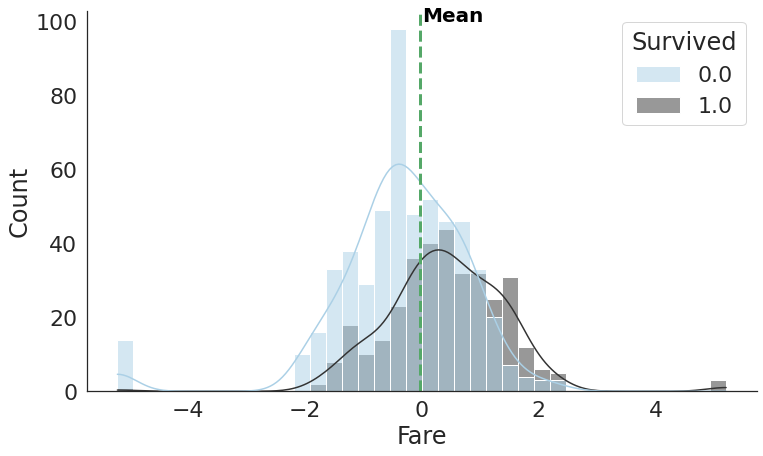

In [62]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.histplot(x="Fare", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
plt.axvline(x=titanic_df['Fare'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(0, 100, "Mean", horizontalalignment='left', size='small', color='black', weight='semibold')
sns.despine()

Let's try Bining.

In [63]:
titanic_df['Fare_class'] = pd.qcut(titanic_df['Fare'], 5, labels=['F1', 'F2', 'F3','F4','F5' ])

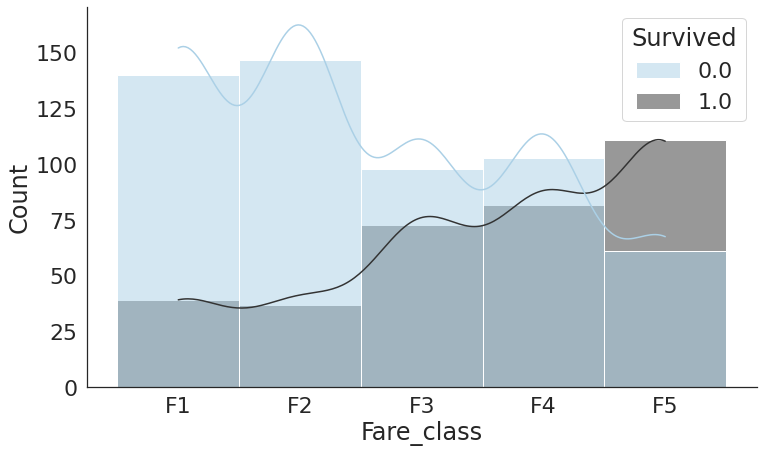

In [64]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.histplot(x="Fare_class", hue="Survived", data=titanic_df,palette = 'Blues_d',kde=True)
sns.despine()

In [65]:
titanic_df['Fare_class'] = titanic_df['Fare_class'].replace({'F1':1,'F2':2,'F3':3,'F4':4,'F5':5})

---------------------------------------
## Embarked

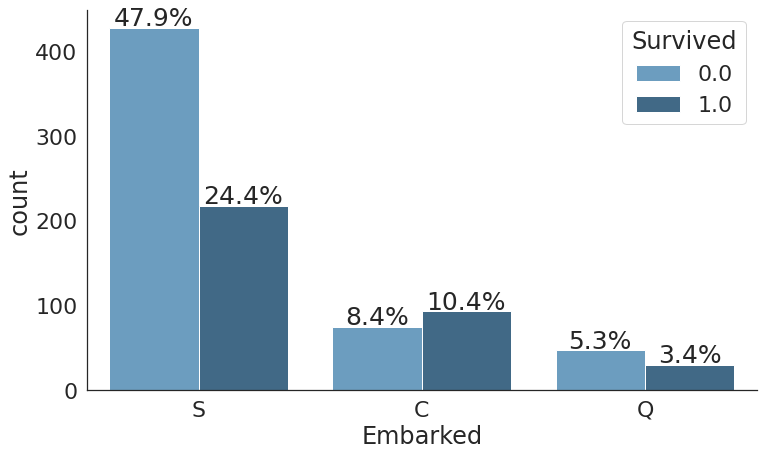

In [66]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(x='Embarked',hue = 'Survived',data=titanic_df,palette="Blues_d")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total_cnt * 100:2.1f}%', ha = 'center', size = 25)
sns.despine()

<span style="color:Blue"> Observation:
    
* Many passengers on board at S port died.
* For passengers boarding at port C, the survival rate is higher than the mortality rate.

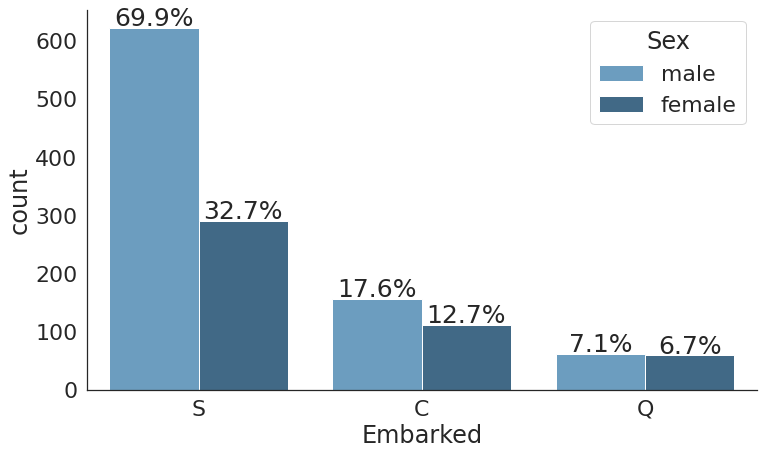

In [67]:
rcParams['figure.figsize'] = 12,7
sns.set_palette("bright")
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(x='Embarked',hue = 'Sex',data=titanic_df,palette="Blues_d")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total_cnt * 100:2.1f}%', ha = 'center', size = 25)
sns.despine()

<span style="color:Blue"> Observation:
    
* Among the passengers who boarded at S port, the proportion of males is higher than that of other ports.

Let's impute missing value for Embarked feature. The strategy for Embarked's missing values is to choose 'most_frequent'.

In [68]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
titanic_df[['Embarked']] = imp.fit_transform(titanic_df[['Embarked']])

------------------------------------------------------------------------------------------
# Checking Missing Value Again
Finally, let's check the missing values.

Number of Missing Values in Dataset  0


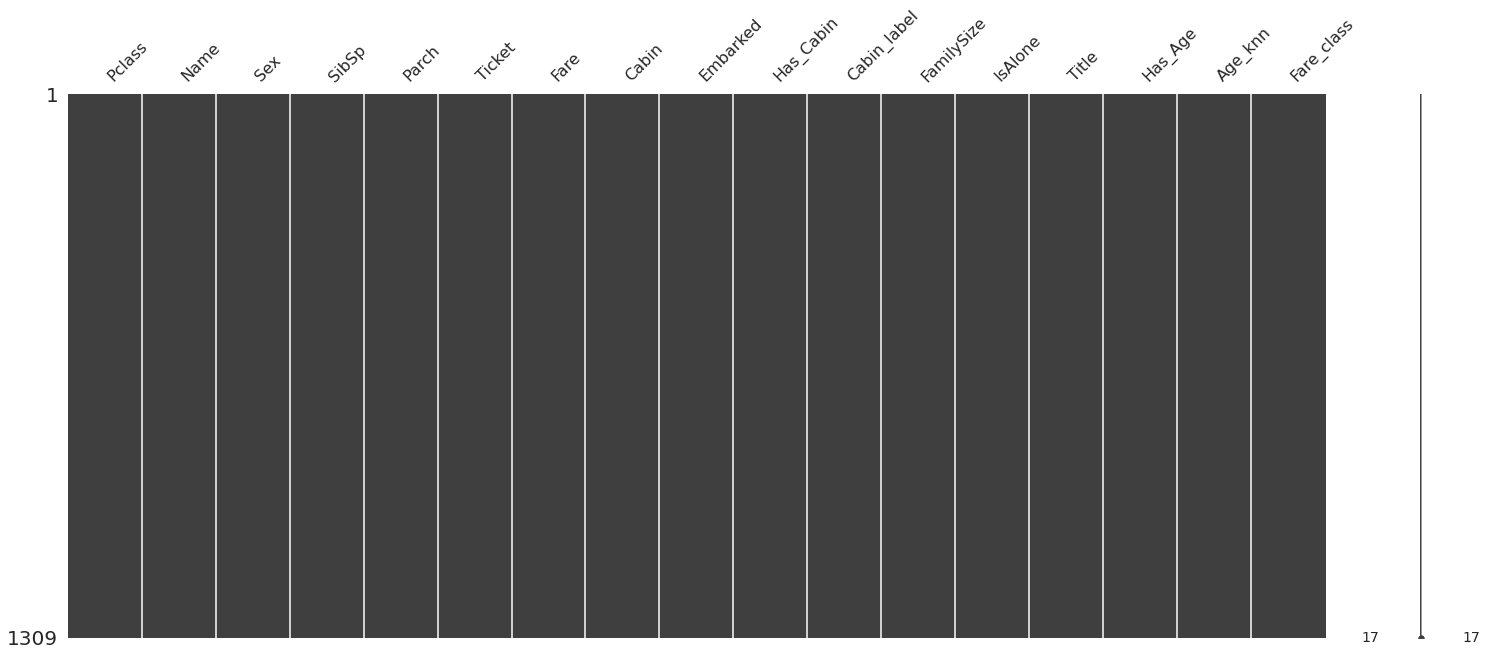

In [69]:
import missingno as msno
msno.matrix(titanic_df.drop('Survived',axis=1))
print('Number of Missing Values in Dataset ',titanic_df.drop('Survived',axis=1).isnull().sum().sum())

**OK! There is no missing values at the train dataset.**

--------------------------------------------------------------------------------------------------
# Detecting Outliers by PCA

![](https://miro.medium.com/max/602/0*PnqMbZEdnuL9yHuo.png)

Picture Credit: https://miro.medium.com

The more features, the higher the dimension. When projecting to a lower dimension through PCA, new insights can be gained. PCA can effectively detect outliers.

PC 1 has the largest variance in the dataset distribution. That is, the outlier in PC 1 is very likely to be real outlier

In [70]:
from sklearn.decomposition import PCA

In [71]:
features = ["Sex","Age_knn","FamilySize","IsAlone",'Embarked','Cabin_label']
titanic_copy = titanic_df[tr_idx].copy()
y_copy = titanic_copy.pop("Survived")
X_copy = titanic_copy.loc[:, features]
encode_features(X_copy,['Sex', 'Embarked','Cabin_label'])
pca, X_pca, loadings = apply_pca(X_copy)
print(loadings)

                  PC1       PC2       PC3       PC4       PC5       PC6
Sex         -0.370042 -0.251657  0.232628  0.856831  0.065821 -0.084437
Age_knn     -0.295021  0.461753  0.536676 -0.085858 -0.635234  0.028839
FamilySize   0.610268 -0.123510  0.242138  0.241910 -0.170336  0.682754
IsAlone     -0.630538 -0.084821 -0.179272 -0.188854  0.137625  0.713080
Embarked    -0.046155 -0.495295  0.706762 -0.389214  0.307284 -0.084430
Cabin_label -0.062417 -0.675045 -0.259963 -0.113113 -0.670647 -0.101367


In [72]:
import plotly.express as px
fig = px.histogram(X_pca.melt(), color="variable", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "PCA Histogram",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)

**Let's check out outliers in PC 1**

In [73]:
pc1_outlier_idx = list(outlier_iqr(X_pca['PC1'])[0])

In [74]:
component = "PC1"

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

train_data.iloc[pc1_outlier_idx,:].style.set_properties(**{'background-color': 'Grey',
                            'color': 'white',
                            'border-color': 'darkblack'})

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
180,181,0,3,"Sage, Miss. Constance Gladys",female,nan,8,2,CA. 2343,69.550000,nan,S
792,793,0,3,"Sage, Miss. Stella Anna",female,nan,8,2,CA. 2343,69.550000,nan,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,nan,8,2,CA. 2343,69.550000,nan,S


<span style="color:Blue"> Observation:
* The Sage family started from S port, there was no Cabin, and the ages were not recorded, and they appear to be a poor and pitiful family with a pclass 3 rating.
* All three females in this family using the Miss title have died.

**The last sad news is that the training dataset is small, so it seems difficult to remove even if the above data are outliers.    
Nevertheless, fortunately, this problem is not a regression problem, but a classification problem. If it is a regression problem, outliers should be removed.**

------------------------------------------------------
# Encoding

Let's perform encoding on categorical features.

When only tree-based models are used, label encoding is sufficient. However, we will use one-hot encoding for model extension in the future.

If you want to know more about the encoding of categorical features, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/preprocessing-encoding-categorical-data)

In [75]:
titanic_df = pd.get_dummies(titanic_df, columns = ['Title','Sex', 'Embarked','Cabin_label'],drop_first=True)
titanic_df.head().T.style.set_properties(**{'background-color': 'lightyellow',
                           'color': 'darkblack',
                           'border-color': 'darkblack'})

,0,1,2,3,4
Survived,0.000000,1.000000,1.000000,1.000000,0.000000
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Thayer)","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,-1.399657,1.191240,-0.604585,0.960549,-0.530220
Cabin,N,C85,N,C123,N
Has_Cabin,1,0,1,0,1
FamilySize,2,2,1,2,1


---------------------------------------
# Checking Correlation

Text(0.5, 1.0, 'Correlation Plot')

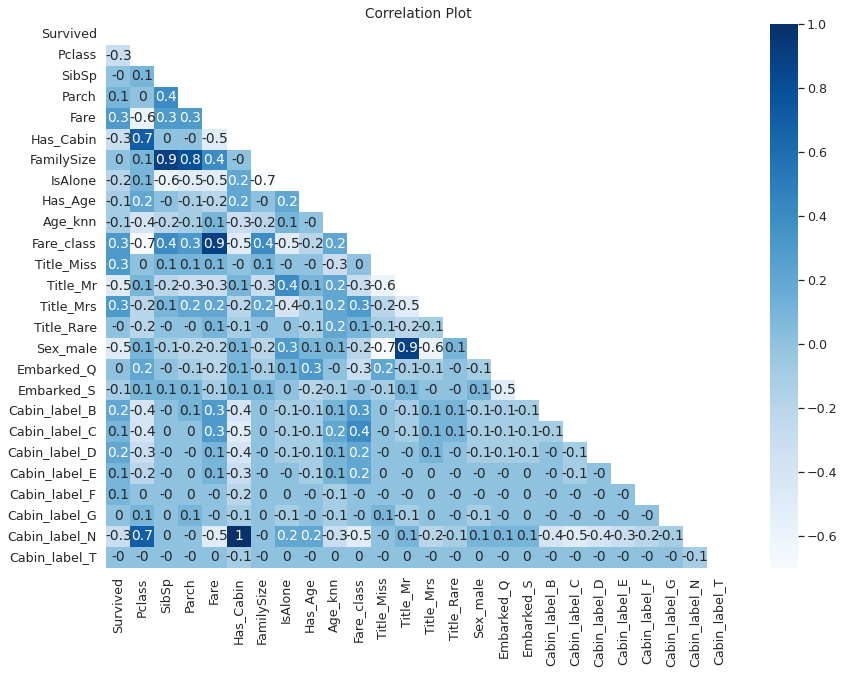

In [76]:
corr=titanic_df.corr().round(1)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_style("white")
sns.set_palette("bright")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='Blues',mask=mask,cbar=True)
plt.title('Correlation Plot')

<span style="color:Blue"> Observation and Decision:
    
* There is a large correlation between FamilySize and SibSp and Parch. Since the derived variable FamilySize is made of SibSp and Parch, SibSp and Parch are removed.
* The relationship between Cabin and Has_Cabin is high. Therefore, the derived variable Has_Cabin is left and Cabin is removed.
* The relationship between Fare and Fare_class is high. Fare is selected because skewness is removed by nonlinear transform of the Fare feature.
* There are many features that are not related to the survived value.

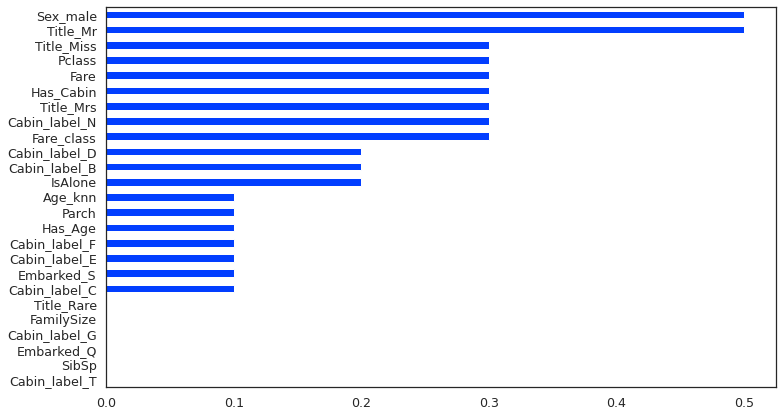

In [77]:
abs(corr['Survived']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')

-------------------------------------------------------------
# Selecting Features

Features that are not helpful in judging the above heatmap and survivors, or that have other derived variables, will be removed.

In [78]:
def drop_features(df):
    df.drop(['Name','Ticket','SibSp','Parch','Fare_class',
             'Cabin','Cabin_label_G','Cabin_label_T',
             'Cabin_label_F','FamilySize','Embarked_Q','Title_Rare'],
            axis=1,
            inplace=True)
    return df

titanic_df = drop_features(titanic_df)

**Let's check the correlation of each feature.**

Text(0.5, 1.0, 'Correlation Plot')

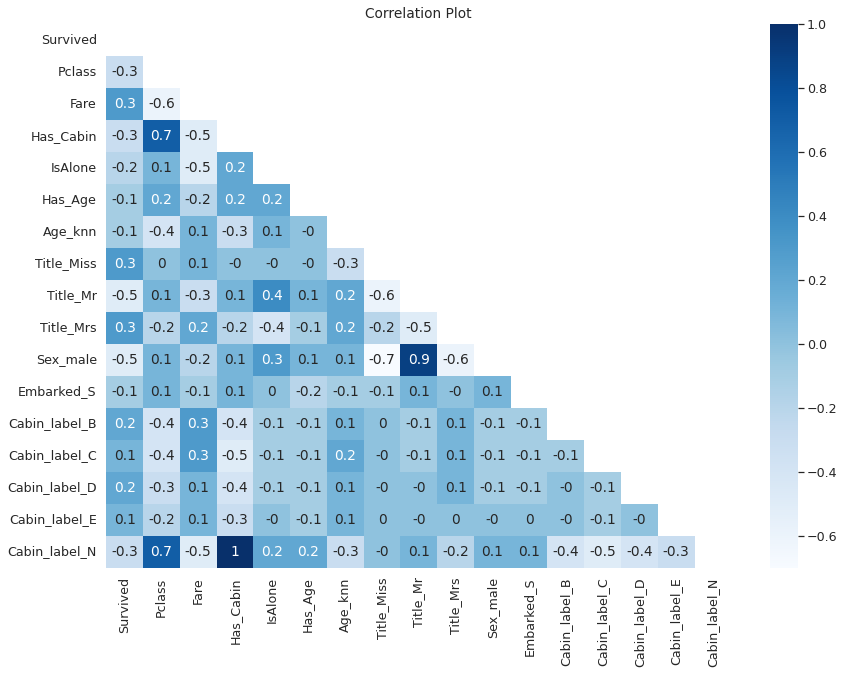

In [79]:
corr=titanic_df.corr().round(1)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_style("white")
sns.set_palette("bright")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='Blues',mask=mask,cbar=True)
plt.title('Correlation Plot')

Let's check the correlation between the target value (Suvived) and other features.

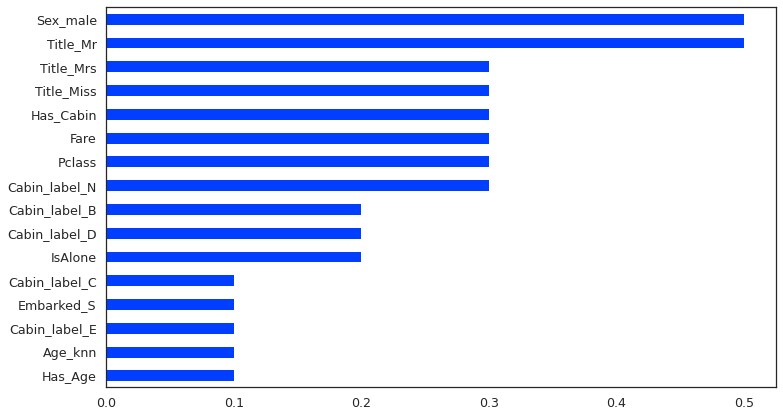

In [80]:
abs(corr['Survived']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')

<Figure size 1008x720 with 0 Axes>

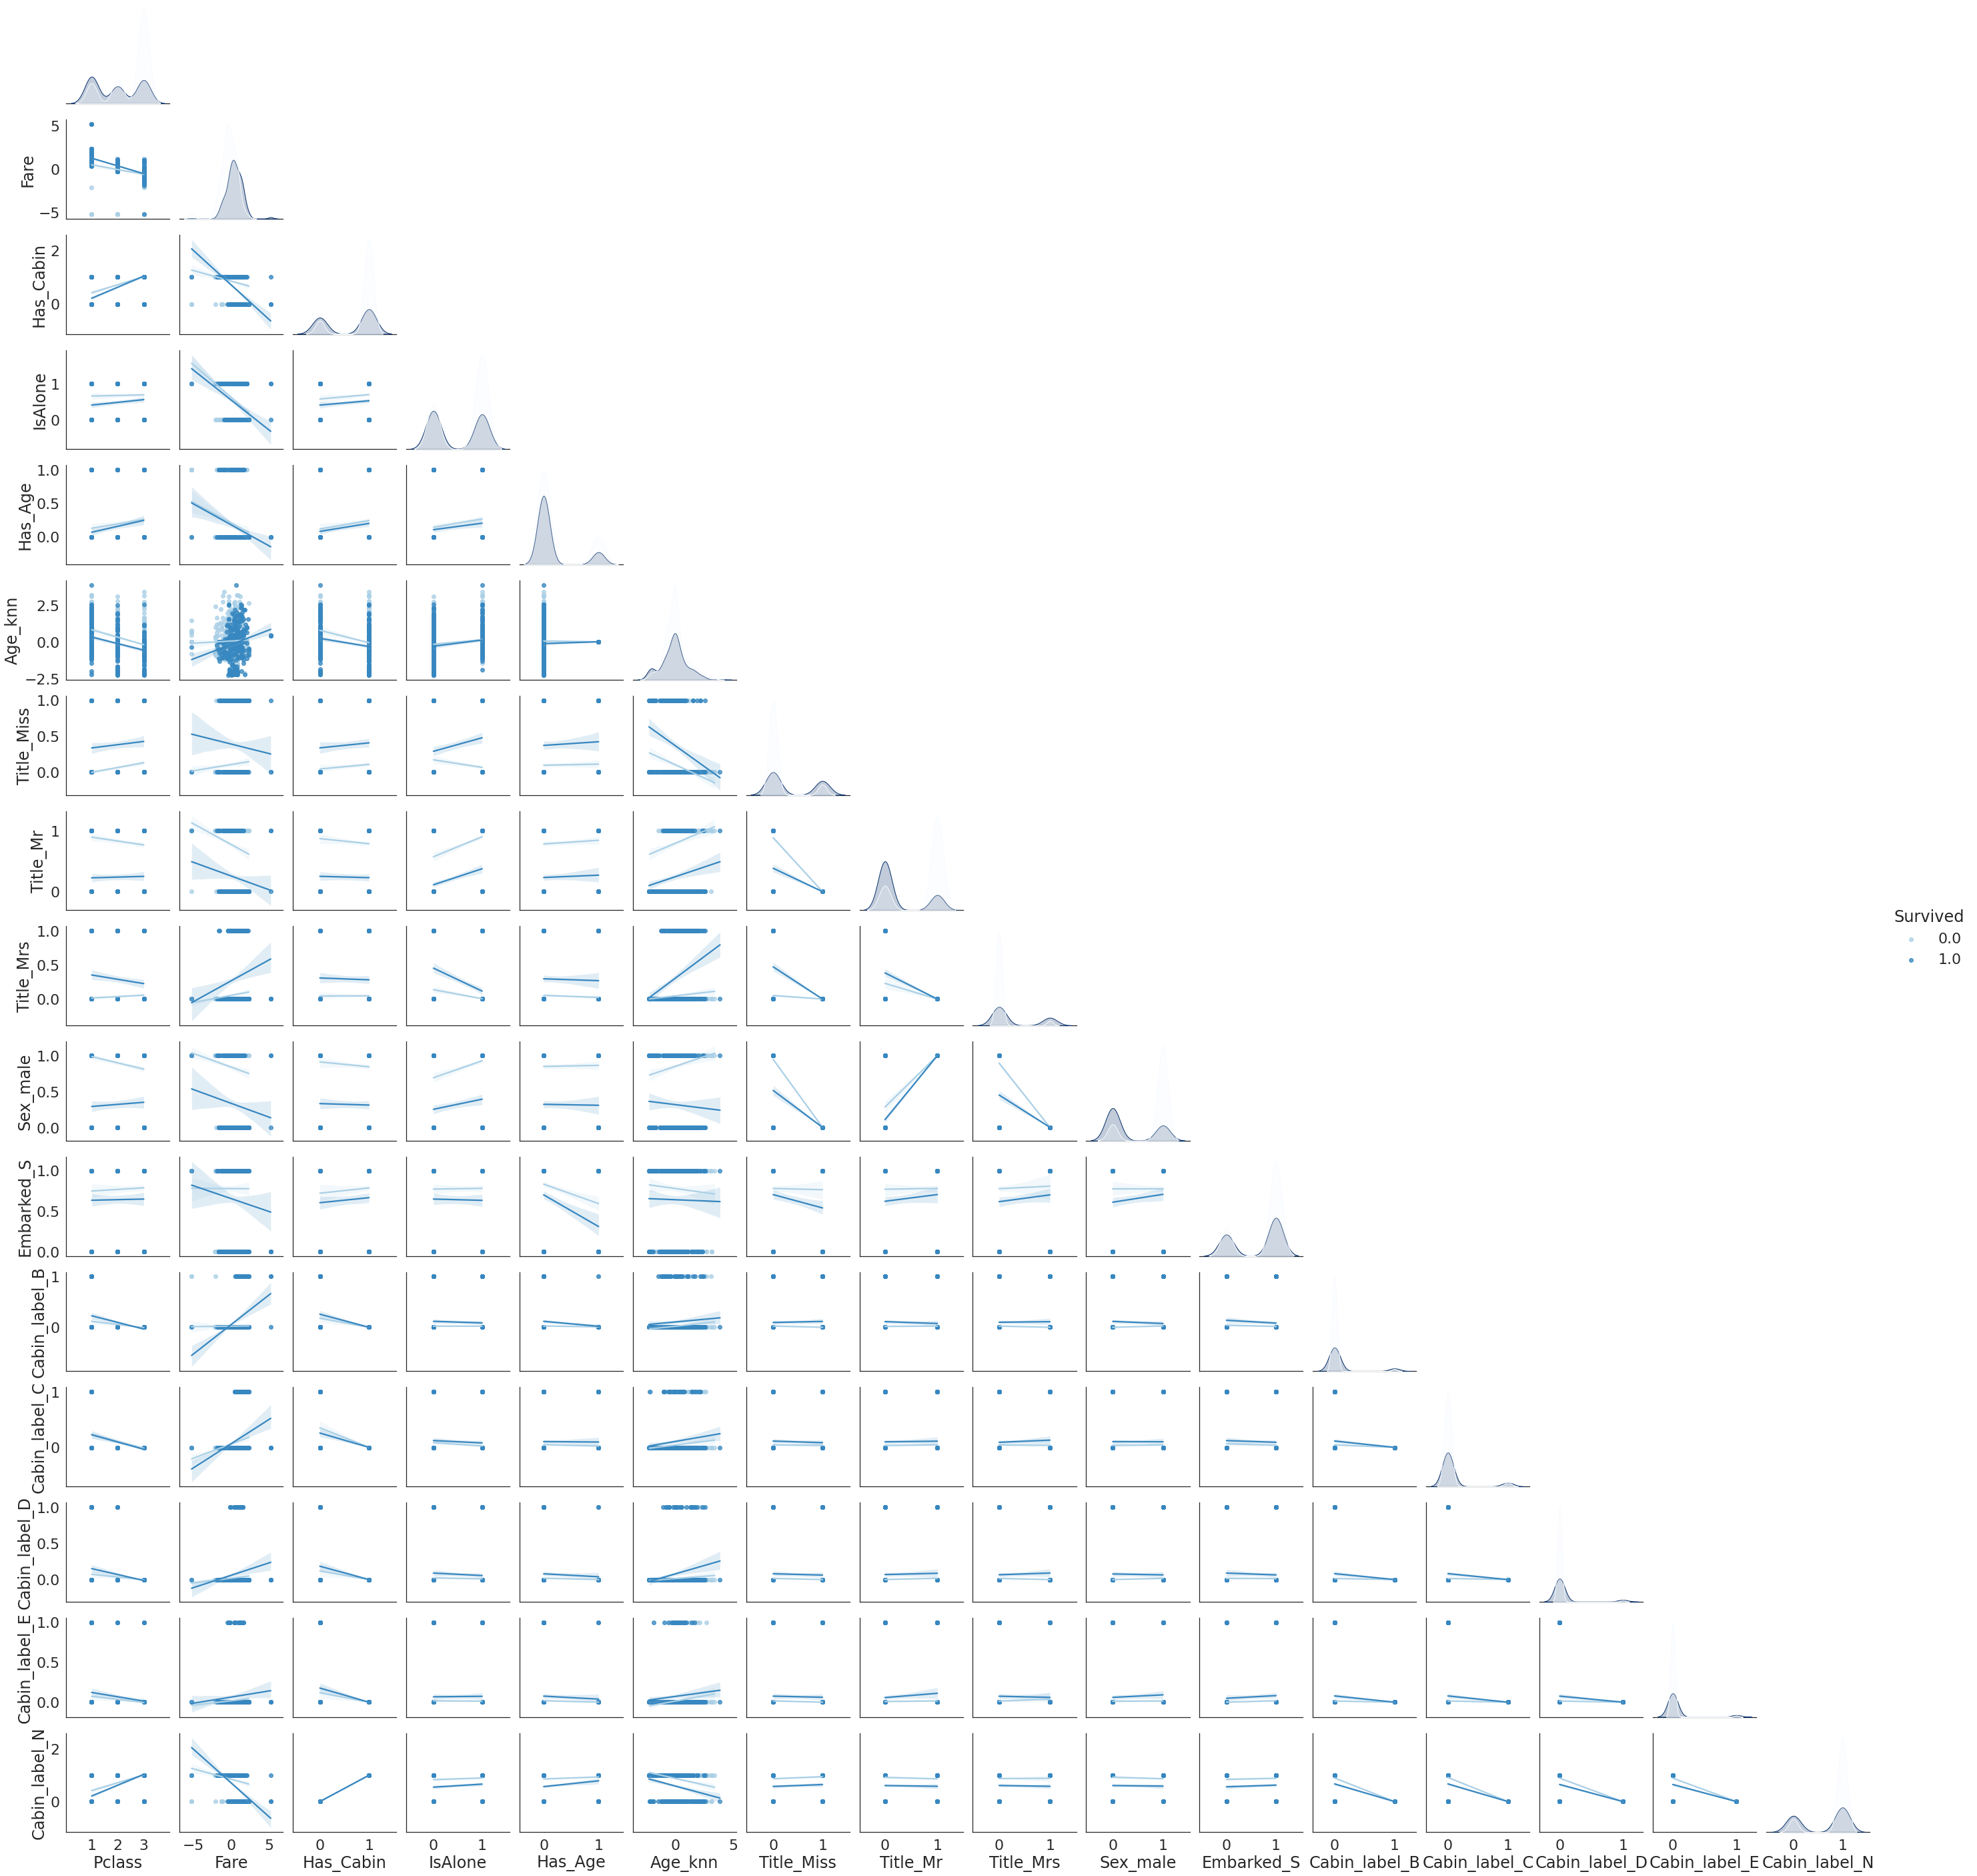

In [81]:
sns.set(font_scale=2)
plt.figure(figsize=(14, 10))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(titanic_df,kind = 'reg',corner = True,palette ='Blues',hue='Survived' )

**OK! Looking at the heatmap and pairplot above, it seems that the features are properly selected.**

# Spliting Train/Validation/Test Data

In [82]:
tr_idx = titanic_df['Survived'].notnull()
y_titanic_df = titanic_df[tr_idx]['Survived']
X_titanic_df= titanic_df[tr_idx].drop('Survived',axis=1)
X_test_df = titanic_df[~tr_idx].drop('Survived',axis=1)

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=11)

In [84]:
y_train.names='Survived'
train_data = pd.concat([X_train,y_train],axis=1)
y_val.names='Survived'
val_data = pd.concat([X_val,y_val],axis=1)

In [85]:
tr_idx = titanic_df['Survived'].notnull()
train_final = titanic_df[tr_idx]

----------------------------------------------------------------------------
# Visualizing Training Dataset after Dimension Reduction

In [86]:
X_train.shape

(712, 16)

The training dataset has 16 dimensions. To show the approximate distribution of the training dataset preprocessed above, let's reduce the dimension to two dimensions and draw it.

<AxesSubplot:>

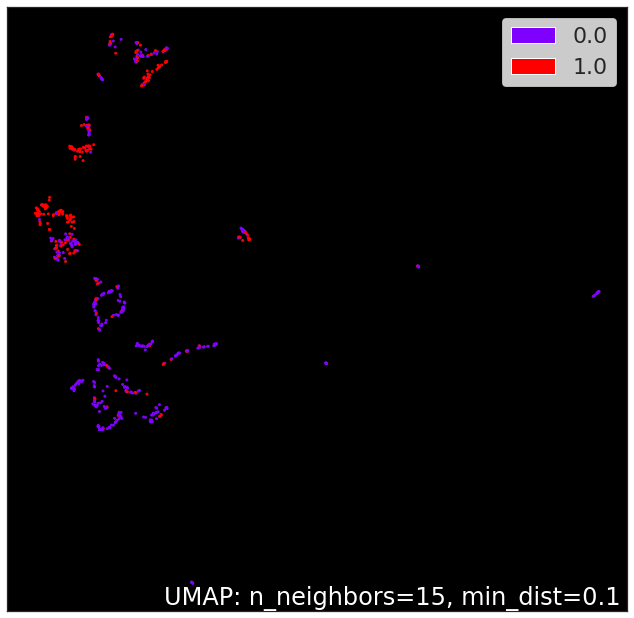

In [87]:
mapper = umap.UMAP().fit(X_train)
umap.plot.points(mapper, labels=y_train, theme='fire')

As shown in the figure above, when viewed in two dimensions, there are quite a few areas where the survivors and the dead overlap. First, let's feel for a moment that the task of classification is a difficult task before learning the model. Our model does this difficult job!

**Thanks models!**

---------------------------------------------------
# Ensemble

![](https://media3.giphy.com/media/26xBvMWzk7FQr54Sk/giphy.gif)

Picture Credit: https://media3.giphy.com


> Empirically, ensembles tend to yield better results when there is a significant diversity among the models.Many ensemble methods, therefore, seek to promote diversity among the models they combine.Although perhaps non-intuitive, more random algorithms (like random decision trees) can be used to produce a stronger ensemble than very deliberate algorithms (like entropy-reducing decision trees).Using a variety of strong learning algorithms, however, has been shown to be more effective than using techniques that attempt to dumb-down the models in order to promote diversity. It is possible to increase diversity in the training stage of the model using correlation for regression tasks or using information measures such as cross entropy for classification tasks

Ref: https://en.wikipedia.org/

## Setting up models

> This function trains and evaluates performance of all estimators available in the model library using cross validation. The output of this function is a score grid with average cross validated scores.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [88]:
all_cols = [cname for cname in X_titanic_df.columns]

In [89]:
from pycaret.classification import *
clf1 = setup(data = train_final, 
             target = 'Survived',
             preprocess = False,
             numeric_features = all_cols,
             silent=True)

,Description,Value
0,session_id,8055
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(891, 17)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Transformed Train Set,"(623, 16)"
9,Transformed Test Set,"(268, 16)"


## Choosing top models

> This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold. 

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [90]:
top5 = compare_models(sort='Accuracy',n_select = 5,
                      exclude = ['knn', 'svm','ridge','nb','dummy','qda','xgboost']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8459,0.8866,0.7361,0.8457,0.7814,0.6642,0.6727,0.1250
gbc,Gradient Boosting Classifier,0.8363,0.8780,0.7234,0.8315,0.7700,0.6443,0.6515,0.0570
catboost,CatBoost Classifier,0.8347,0.8843,0.7317,0.8210,0.7693,0.6418,0.6482,1.2210
lr,Logistic Regression,0.8233,0.8704,0.7692,0.7719,0.7669,0.6249,0.6286,0.4350
lda,Linear Discriminant Analysis,0.8185,0.8664,0.7609,0.7664,0.7603,0.6145,0.6180,0.0110
rf,Random Forest Classifier,0.8122,0.8774,0.7192,0.7815,0.7426,0.5959,0.6029,0.3080
et,Extra Trees Classifier,0.8107,0.8542,0.7236,0.7745,0.7440,0.5944,0.5992,0.2790
ada,Ada Boost Classifier,0.8089,0.8487,0.7361,0.7635,0.7475,0.5939,0.5964,0.0600
dt,Decision Tree Classifier,0.7945,0.7829,0.7406,0.7388,0.7338,0.5672,0.5728,0.0100


In [91]:
top5

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=8055, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
           

## Creating Models

> This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold. 

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [92]:
catboost = create_model('catboost')
rf = create_model('rf')
lightgbm = create_model('lightgbm')
#mlp = create_model('mlp')
gbc = create_model('gbc')
lda = create_model('lda')
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8571,0.9103,0.7917,0.8261,0.8085,0.6947,0.6951
1,0.8571,0.8771,0.8333,0.8000,0.8163,0.6995,0.6999
2,0.8413,0.8835,0.8333,0.7692,0.8000,0.6688,0.6702
3,0.8065,0.8540,0.6087,0.8235,0.7000,0.5618,0.5758
4,0.8387,0.8991,0.7500,0.8182,0.7826,0.6548,0.6564
5,0.8387,0.8717,0.8333,0.7692,0.8000,0.6652,0.6667
6,0.8387,0.9112,0.8333,0.7692,0.8000,0.6652,0.6667
7,0.6935,0.7796,0.6250,0.6000,0.6122,0.3591,0.3593
8,0.7742,0.7785,0.6250,0.7500,0.6818,0.5090,0.5141
9,0.8871,0.9386,0.9583,0.7931,0.8679,0.7709,0.7814


# Interpreting Models

This function analyzes the predictions generated from a trained model. Most plots in this function are implemented based on the SHAP (SHapley Additive exPlanations).

> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Ref: https://shap.readthedocs.io/en/latest/

**If you want to know more about feature importance and SHAP, please refer to the notebook below.**

[Notebook](https://www.kaggle.com/ohseokkim/explaning-machine-by-feature-importnace)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

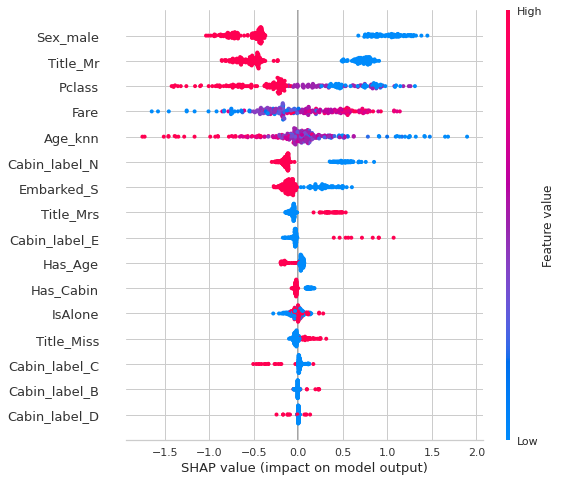

In [93]:
interpret_model(catboost)

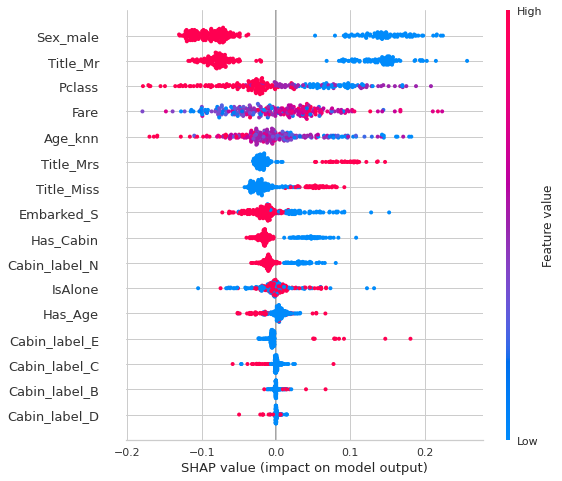

In [94]:
interpret_model(rf)

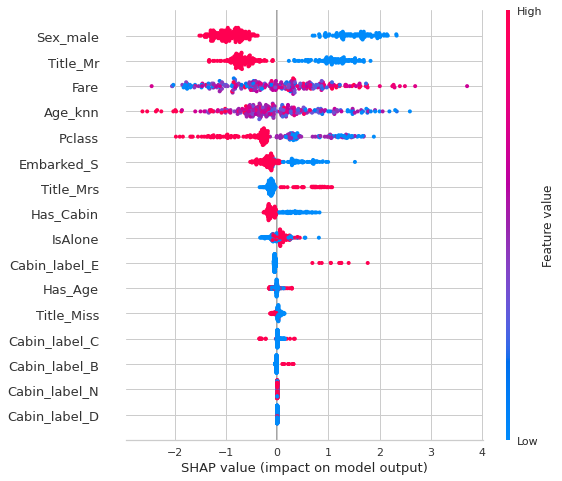

In [95]:
interpret_model(lightgbm)

<span style="color:Blue"> Observation:
* Among the features, if you look at Fare and Age_knn, the features are spread in a wide distribution of importance, and the colors are also spread from blue to red. 
* Each model is learning with the importance of different features. The diversity of these models seems to increase the performance of the ensemble model.
* Title_Mr and Sex_male play an important role in how the model learns.

# Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter. 

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [96]:
tuned_rf = tune_model(rf, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9048,0.8600,0.7917,0.9500,0.8636,0.7914,0.7992
1,0.7937,0.8697,0.7083,0.7391,0.7234,0.5590,0.5593
2,0.8730,0.8600,0.8333,0.8333,0.8333,0.7308,0.7308
3,0.8065,0.8963,0.6522,0.7895,0.7143,0.5699,0.5759
4,0.8710,0.9298,0.8333,0.8333,0.8333,0.7281,0.7281
5,0.8387,0.8947,0.7083,0.8500,0.7727,0.6493,0.6558
6,0.8548,0.9156,0.7917,0.8261,0.8085,0.6917,0.6921
7,0.7419,0.7818,0.6250,0.6818,0.6522,0.4477,0.4487
8,0.8226,0.8289,0.6667,0.8421,0.7442,0.6112,0.6209
9,0.8871,0.9485,0.9167,0.8148,0.8627,0.7674,0.7713


In [97]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8889,0.9257,0.7917,0.9048,0.8444,0.7586,0.7627
1,0.8571,0.8809,0.7917,0.8261,0.8085,0.6947,0.6951
2,0.8095,0.8007,0.6667,0.8000,0.7273,0.5828,0.5885
3,0.8548,0.8790,0.6957,0.8889,0.7805,0.6744,0.6858
4,0.8387,0.9309,0.8333,0.7692,0.8000,0.6652,0.6667
5,0.8548,0.8712,0.7917,0.8261,0.8085,0.6917,0.6921
6,0.8387,0.9112,0.7500,0.8182,0.7826,0.6548,0.6564
7,0.8065,0.8706,0.6667,0.8000,0.7273,0.5792,0.5850
8,0.8387,0.8048,0.6250,0.9375,0.7500,0.6379,0.6664
9,0.8871,0.9002,0.9167,0.8148,0.8627,0.7674,0.7713


In [98]:
tuned_catboost = tune_model(catboost, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8571,0.9017,0.7083,0.8947,0.7907,0.6845,0.6952
1,0.8571,0.8536,0.7917,0.8261,0.8085,0.6947,0.6951
2,0.7778,0.8408,0.6667,0.7273,0.6957,0.5212,0.5224
3,0.7903,0.9103,0.5652,0.8125,0.6667,0.5208,0.5391
4,0.8871,0.9221,0.8333,0.8696,0.8511,0.7602,0.7607
5,0.8548,0.8882,0.7500,0.8571,0.8000,0.6869,0.6906
6,0.8871,0.9079,0.8333,0.8696,0.8511,0.7602,0.7607
7,0.7742,0.8169,0.6667,0.7273,0.6957,0.5167,0.5179
8,0.8387,0.8311,0.6250,0.9375,0.7500,0.6379,0.6664
9,0.9032,0.9452,0.9167,0.8462,0.8800,0.7991,0.8009


In [99]:
tuned_gbc = tune_model(gbc, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8730,0.9348,0.8333,0.8333,0.8333,0.7308,0.7308
1,0.8413,0.8921,0.7917,0.7917,0.7917,0.6635,0.6635
2,0.7937,0.8397,0.6667,0.7619,0.7111,0.5517,0.5547
3,0.8710,0.8974,0.7391,0.8947,0.8095,0.7133,0.7207
4,0.8710,0.9463,0.8333,0.8333,0.8333,0.7281,0.7281
5,0.7903,0.8882,0.6667,0.7619,0.7111,0.5477,0.5507
6,0.8710,0.9046,0.8333,0.8333,0.8333,0.7281,0.7281
7,0.7742,0.8191,0.7083,0.7083,0.7083,0.5241,0.5241
8,0.8065,0.7939,0.5417,0.9286,0.6842,0.5582,0.6004
9,0.8710,0.9353,0.9167,0.7857,0.8462,0.7362,0.7427


In [100]:
tuned_lda = tune_model(lda, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8571,0.9113,0.7917,0.8261,0.8085,0.6947,0.6951
1,0.8413,0.8771,0.7917,0.7917,0.7917,0.6635,0.6635
2,0.8413,0.8857,0.8333,0.7692,0.8000,0.6688,0.6702
3,0.8065,0.8450,0.6087,0.8235,0.7000,0.5618,0.5758
4,0.8871,0.9035,0.7917,0.9048,0.8444,0.7565,0.7606
5,0.8226,0.8695,0.8333,0.7407,0.7843,0.6345,0.6377
6,0.8226,0.9068,0.8333,0.7407,0.7843,0.6345,0.6377
7,0.6452,0.7555,0.5000,0.5455,0.5217,0.2405,0.2411
8,0.7742,0.7829,0.6250,0.7500,0.6818,0.5090,0.5141
9,0.8871,0.9419,0.9583,0.7931,0.8679,0.7709,0.7814


In [101]:
tuned_lr = tune_model(lr, optimize = 'Accuracy',early_stopping = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8571,0.9103,0.7917,0.8261,0.8085,0.6947,0.6951
1,0.8571,0.8750,0.8333,0.8000,0.8163,0.6995,0.6999
2,0.8413,0.8825,0.8333,0.7692,0.8000,0.6688,0.6702
3,0.7903,0.8495,0.6087,0.7778,0.6829,0.5298,0.5386
4,0.8226,0.9013,0.7500,0.7826,0.7660,0.6232,0.6236
5,0.8387,0.8717,0.8333,0.7692,0.8000,0.6652,0.6667
6,0.8387,0.9090,0.8333,0.7692,0.8000,0.6652,0.6667
7,0.6774,0.7884,0.5833,0.5833,0.5833,0.3202,0.3202
8,0.7742,0.7675,0.6250,0.7500,0.6818,0.5090,0.5141
9,0.8871,0.9364,0.9583,0.7931,0.8679,0.7709,0.7814


## Stacking

In [102]:
# stack top5 models
stack_model = stack_models(estimator_list = [lr,rf,lightgbm,catboost,gbc,lda], meta_model = top5[0] ,optimize = 'Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8730,0.8900,0.7500,0.9000,0.8182,0.7219,0.7289
1,0.7937,0.8568,0.7917,0.7037,0.7451,0.5728,0.5756
2,0.7937,0.7938,0.6667,0.7619,0.7111,0.5517,0.5547
3,0.8226,0.8384,0.6087,0.8750,0.7179,0.5945,0.6154
4,0.8548,0.8783,0.7917,0.8261,0.8085,0.6917,0.6921
5,0.8387,0.8432,0.6667,0.8889,0.7619,0.6437,0.6589
6,0.8710,0.8936,0.7500,0.9000,0.8182,0.7195,0.7266
7,0.7742,0.7851,0.6250,0.7500,0.6818,0.5090,0.5141
8,0.7903,0.8333,0.5417,0.8667,0.6667,0.5253,0.5562
9,0.8710,0.9068,0.9167,0.7857,0.8462,0.7362,0.7427


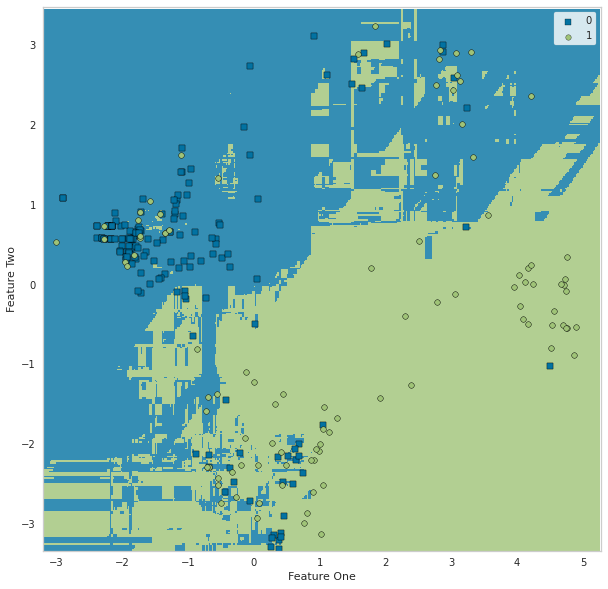

In [103]:
plt.figure(figsize=(10, 10))
plot_model(stack_model, plot='boundary')

In machine learning, it is important to determine the boundary. In particular, in tree-based models, it is more important to determine the boundary, because the process of creating a new leaf in the tree is also the process of determining the boundary.
Looking at the above picture again, there are many overlapping points with the green dot indicating the survior and the blue dot indicating the non-survior. Determining the boundary in this situation would be a very difficult task.
If the feature engineer work was done well, the distribution of the two points to determine the boundary would have been well divided. However, the titanic dataset is difficult to do with some missing values ​​and a small dataset.

Let's look again at the picture above.
Boundary is not very clean. It can be judged that overfitting has occurred, and therefore it can be judged that it does not have generality.

If you want to know more about overfitting, please refer to the notebook below.

[Notebook](https://www.kaggle.com/ohseokkim/overfitting-and-underfitting-eda)

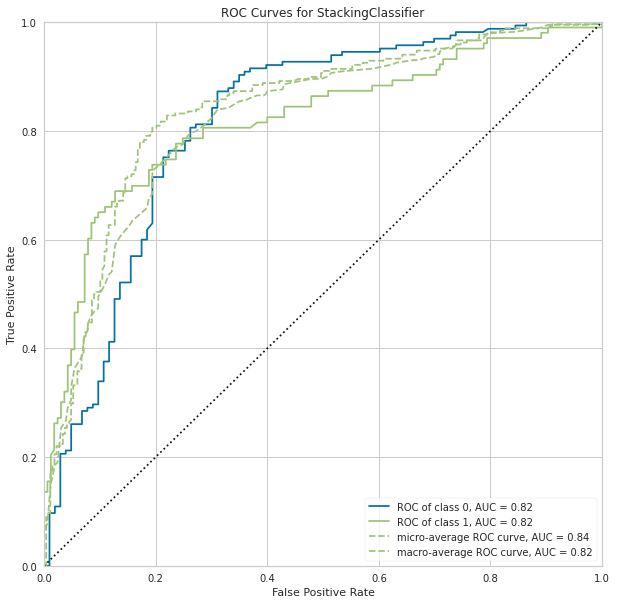

In [104]:
plt.figure(figsize=(10, 10))
plot_model(stack_model, plot = 'auc')

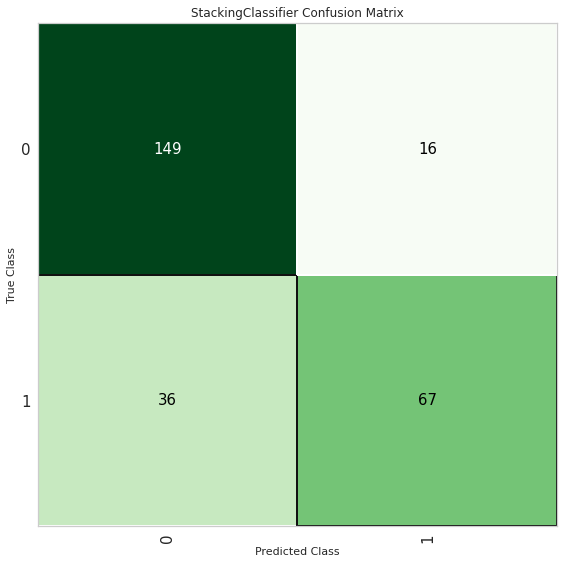

In [105]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='confusion_matrix')

## Soft Blending

In [106]:
blend_soft = blend_models(estimator_list = [lr,rf,lightgbm,catboost,gbc,lda], optimize = 'Accuracy',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8730,0.9231,0.7500,0.9000,0.8182,0.7219,0.7289
1,0.8413,0.8900,0.7917,0.7917,0.7917,0.6635,0.6635
2,0.7778,0.8707,0.6667,0.7273,0.6957,0.5212,0.5224
3,0.8226,0.8986,0.6087,0.8750,0.7179,0.5945,0.6154
4,0.9032,0.9276,0.8333,0.9091,0.8696,0.7929,0.7948
5,0.8387,0.8783,0.7500,0.8182,0.7826,0.6548,0.6564
6,0.8871,0.9178,0.8333,0.8696,0.8511,0.7602,0.7607
7,0.7419,0.8092,0.6250,0.6818,0.6522,0.4477,0.4487
8,0.7903,0.8202,0.5833,0.8235,0.6829,0.5330,0.5507
9,0.8871,0.9452,0.9167,0.8148,0.8627,0.7674,0.7713


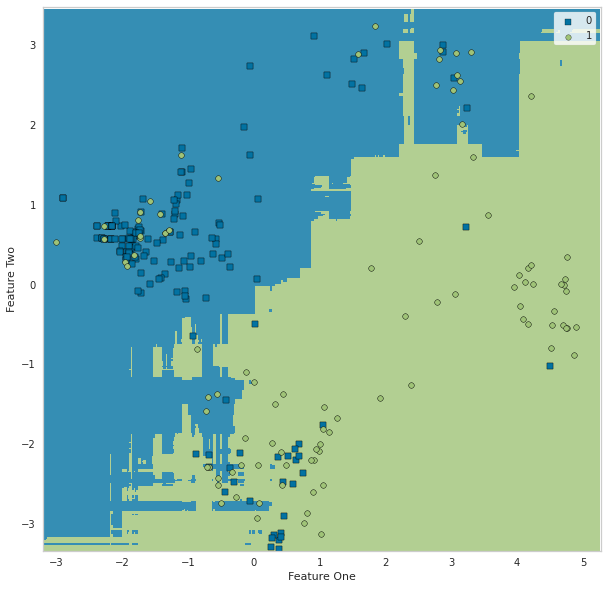

In [107]:
plt.figure(figsize=(10, 10))
plot_model(blend_soft, plot='boundary')

It seems that the Boundary is set properly.

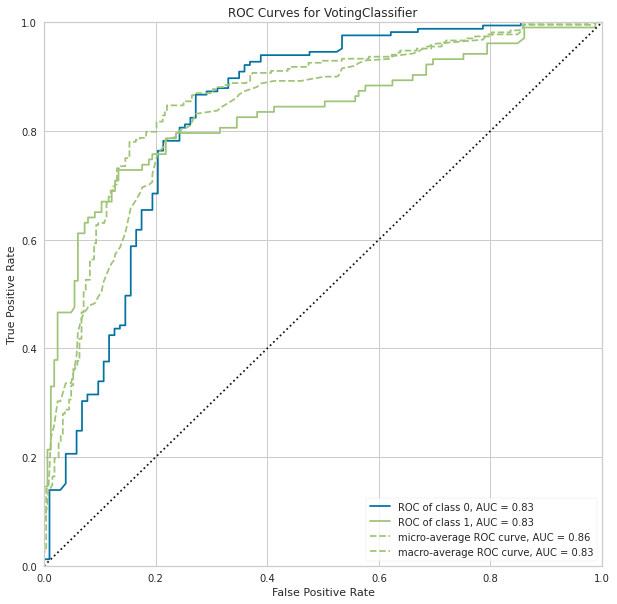

In [108]:
plt.figure(figsize=(10, 10))
plot_model(blend_soft, plot = 'auc')

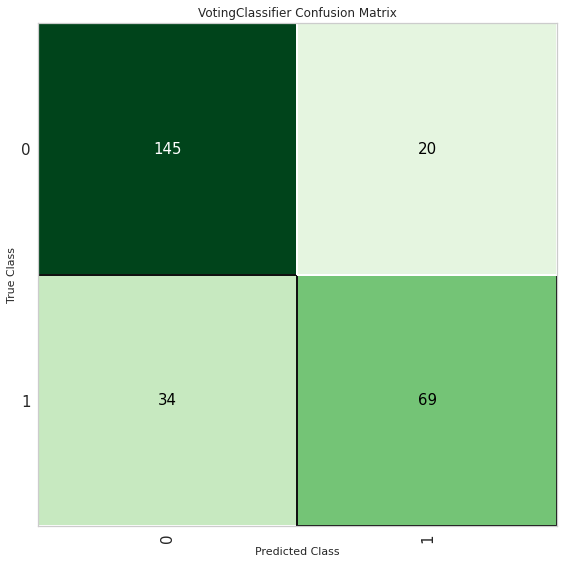

In [109]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='confusion_matrix')

## Hard Blending

In [110]:
blend_hard = blend_models(estimator_list = [lr,rf,lightgbm,catboost,gbc,lda], optimize = 'Accuracy',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8889,0.0000,0.7917,0.9048,0.8444,0.7586,0.7627
1,0.8571,0.0000,0.7917,0.8261,0.8085,0.6947,0.6951
2,0.7778,0.0000,0.6667,0.7273,0.6957,0.5212,0.5224
3,0.8226,0.0000,0.6087,0.8750,0.7179,0.5945,0.6154
4,0.8710,0.0000,0.7917,0.8636,0.8261,0.7238,0.7256
5,0.8387,0.0000,0.7083,0.8500,0.7727,0.6493,0.6558
6,0.8710,0.0000,0.8333,0.8333,0.8333,0.7281,0.7281
7,0.7581,0.0000,0.5833,0.7368,0.6512,0.4698,0.4773
8,0.8065,0.0000,0.5833,0.8750,0.7000,0.5654,0.5908
9,0.8871,0.0000,0.9167,0.8148,0.8627,0.7674,0.7713


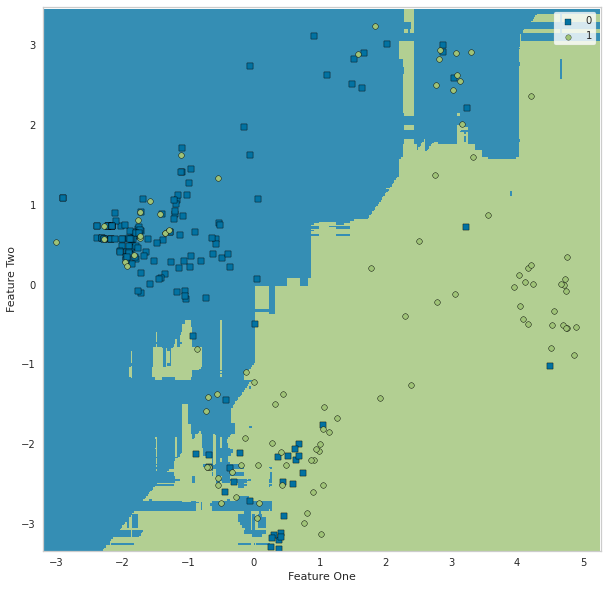

In [111]:
plt.figure(figsize=(10, 10))
plot_model(blend_hard, plot='boundary')

Compared to the soft blending model, the boundary does not look clean.

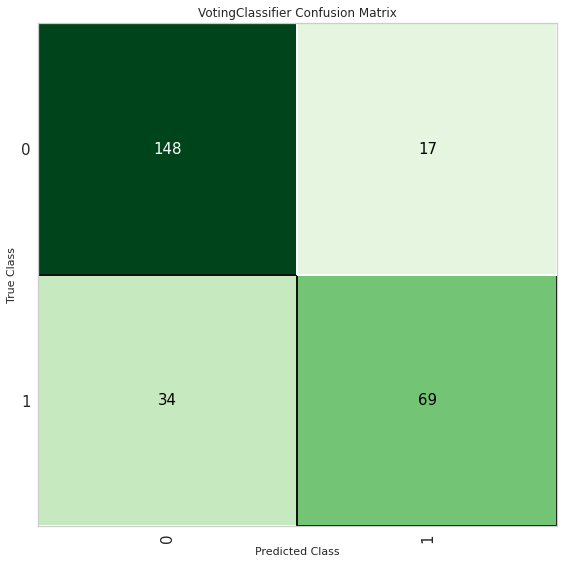

In [112]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='confusion_matrix')

-------------------------------------------------------------------------------------------------
## Calibrating the final model

> This function calibrates the probability of a given estimator using isotonic or logistic regression. 


In [113]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8730,0.9199,0.7500,0.9000,0.8182,0.7219,0.7289
1,0.8413,0.8932,0.7917,0.7917,0.7917,0.6635,0.6635
2,0.7778,0.8665,0.6667,0.7273,0.6957,0.5212,0.5224
3,0.8226,0.9108,0.6087,0.8750,0.7179,0.5945,0.6154
4,0.9032,0.9353,0.8333,0.9091,0.8696,0.7929,0.7948
5,0.8387,0.8684,0.7500,0.8182,0.7826,0.6548,0.6564
6,0.8710,0.9178,0.8333,0.8333,0.8333,0.7281,0.7281
7,0.7258,0.8257,0.6250,0.6522,0.6383,0.4177,0.4179
8,0.8226,0.8213,0.6667,0.8421,0.7442,0.6112,0.6209
9,0.8871,0.9441,0.9167,0.8148,0.8627,0.7674,0.7713


--------------------------------------------------
# Finalizing the last model
> This function trains a given estimator on the entire dataset including the holdout set.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

The blend_soft model is selected based on the above result. Finally, the model is tuned with the entire dataset.


In [114]:
final_model = finalize_model(cali_model)

## Checking the final model

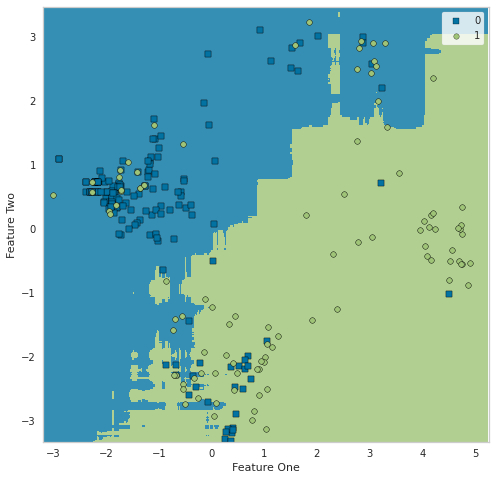

In [115]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

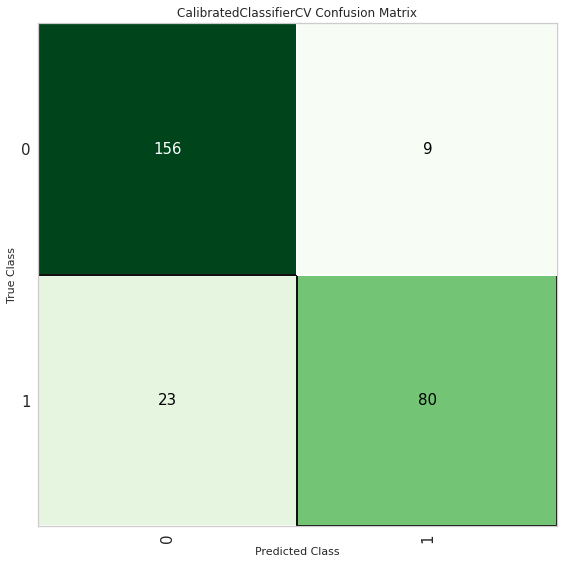

In [116]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='confusion_matrix')

---------------------------------------
# Checking Last Results

Considering above results, the soft blending model seems appropriate among ensemble models. Therefore, we use this model to make the final prediction with the test dataset.

In [117]:
last_prediction = final_model.predict(X_test_df)
submission_data['Survived'] = last_prediction.astype(int)
submission_data.to_csv('submission.csv', index = False)